In [1]:
#%%
import sys
sys.path.append('/home/gaoyuanw/Github/JaxSSO')
import JaxSSO.model as Model 
from JaxSSO import assemblemodel,solver
from JaxSSO.SSO_model import NodeParameter,ElementParameter,SSO_model
import numpy as np
import jax
import jax.numpy as jnp
from jax import jacfwd,grad,value_and_grad
from scipy.sparse.linalg import spsolve as spsolve_scipy
from scipy.sparse import csr_matrix
from jax.experimental import sparse
import os
#os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["TF_CPP_MIN_LOG_LEVEL"]="0"
jax.config.update("jax_enable_x64", True)
from jax.experimental import sparse
print(jax.__version__)
from platform import python_version
jax.config.update('jax_platform_name', 'cpu')
print(python_version())
import scipy
print(scipy.__version__)

import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.patches import Polygon

0.4.24
3.12.1
1.12.0


/tmp/ipykernel_2930901/734137169.py:27: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
n_col =40
n_row = n_col
x_span = 6
y_span = 6


# Nodal coordinates
xs = np.linspace(0,x_span,n_col+1)
xs = np.tile(xs,n_row+1)
ys = np.linspace(0,y_span,n_row+1)
ys = np.tile(ys,(n_col+1,1))
ys = ys.T.reshape(-1)
#zs =  0.2*(-(np.linspace(0,x_span,n_col+1)-x_span/2)**2+(x_span/2)**2)

zs =  0.1*(-(xs-x_span/2)**2+(x_span/2)**2
          -(ys-x_span/2)**2+(x_span/2)**2)

'''zs = np.tile(zs,n_row+1)
zs = np.where(xs==0,0,zs)
zs = np.where(xs==x_span,0,zs)'''
'''zs = np.where(xs==0,0,zs)
zs = np.where(xs==x_span,0,zs)
zs = np.where(ys==0,0,zs)
zs = np.where(ys==y_span,0,zs)
'''

# Connectivity
n_node = (n_col+1)*(n_row+1)
n_ele = n_col * n_row
cnct = np.zeros((n_ele,4),dtype=int) #Connectivity for MITC4
for i in range(n_ele):
    i_row = i//n_col
    i_col = (i-i_row*n_col)%n_col
    cnct[i,3] = i + i_row*1 + n_col + 1
    cnct[i,2] = cnct[i,3]+1 
    cnct[i,1] = cnct[i,2] - (n_col + 1)
    cnct[i,0] = cnct[i,1] - 1

#Properties, design nodes, load
t = 0.015
E = 2e10
nu = 0.3
design_nodes = []
non_design_nodes = []
loading_nodes = []
for i in range(n_node):
    design_nodes.append(i)
    if [xs[i],ys[i]]!= [x_span/2,0] and [xs[i],ys[i]] != [0,y_span/2] and [xs[i],ys[i]] != [x_span/2,y_span] and [xs[i],ys[i]] != [x_span,y_span/2]:
        #design_nodes.append(i)
        if [xs[i],ys[i]]== [0,0] or [xs[i],ys[i]]== [x_span/2,y_span/2] or [xs[i],ys[i]]== [x_span,0] or [xs[i],ys[i]]== [0,y_span] or [xs[i],ys[i]]== [x_span,y_span]:
            loading_nodes.append(i)
        
    else:
        non_design_nodes.append(i)
design_nodes = np.asarray(design_nodes)
non_design_nodes = np.asarray(non_design_nodes)
Q = 500

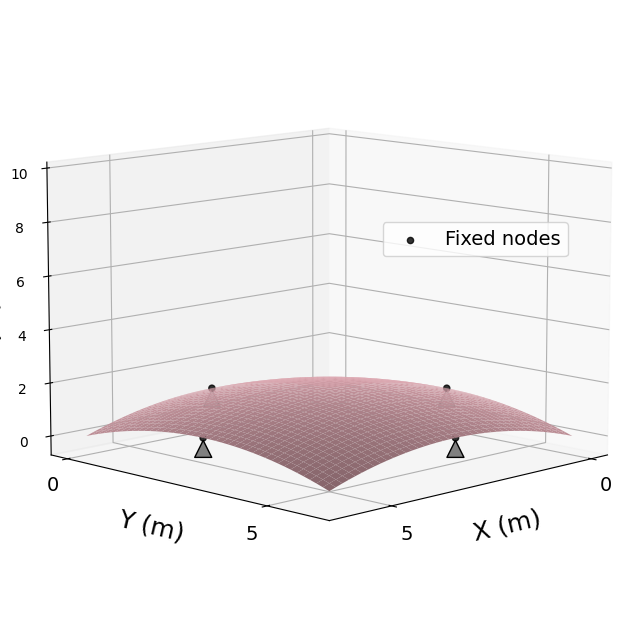

In [3]:
col = n_col+1
row = n_row+1 
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')
X = xs.reshape((row,col))
Y = ys.reshape((row,col))
Z = zs.reshape((row,col))
ax.set_xlabel('X (m)',fontsize=18)
ax.set_ylabel('Y (m)',fontsize=18)
ax.set_zlabel('Z (m)',fontsize=18)
plt.yticks([0,5,10,15,20],fontsize=14)
plt.xticks([0,5,10,15,20],fontsize=14)

ax.set_zlim(-0.5, 20)
ax.set_zlim(-0.5, 20)
ax.set_zlim(-0.5, 10)
ax.plot_surface(X, Y, Z, color='pink')#cmap=plt.cm.YlGnBu_r) 
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes],color='black',alpha=0.8,label='Fixed nodes',s=20)
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes]-0.4, s=150, facecolors='grey', edgecolors='black',marker='^')
ax.view_init(10, 45)
plt.legend(loc=(0.6,0.6),fontsize=14)

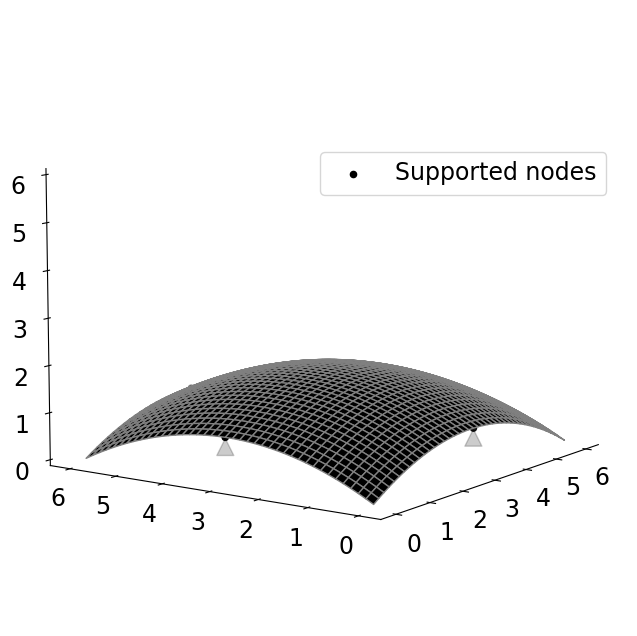

In [4]:
%matplotlib inline




fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.set_zlim(0,6)
#ax.set_xlabel('X (m)',fontsize=15)
#ax.set_ylabel('Y (m)',fontsize=15)
#ax.set_zlabel('Z (m)',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=17)
ax.tick_params(axis='both', which='minor', labelsize=17)
#Plot a basic wireframe.
#for i in range(n_ele_bar):
  #ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],[z_ele[i,0],z_ele[i,1]],color='black')

all_corners = []


for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    all_corners.append([[xs[inode],ys[inode],zs[inode]],
                        [xs[jnode],ys[jnode],zs[jnode]],
                        [xs[mnode],ys[mnode],zs[mnode]],
                        [xs[nnode],ys[nnode],zs[nnode]],
                       ])

tdco = Poly3DCollection(all_corners)
tdco.set_alpha(1)
tdco.set_facecolor('black')
tdco.set_edgecolor('grey')
ax.add_collection3d(tdco)

ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes],color='black',label='Supported nodes')
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes]-0.2,s=150,marker='^',alpha=0.2,color='black')
ax.view_init(10, -145)
plt.legend(fontsize=17, loc=(0.5,0.7))
ax.grid(False)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
plt.show()

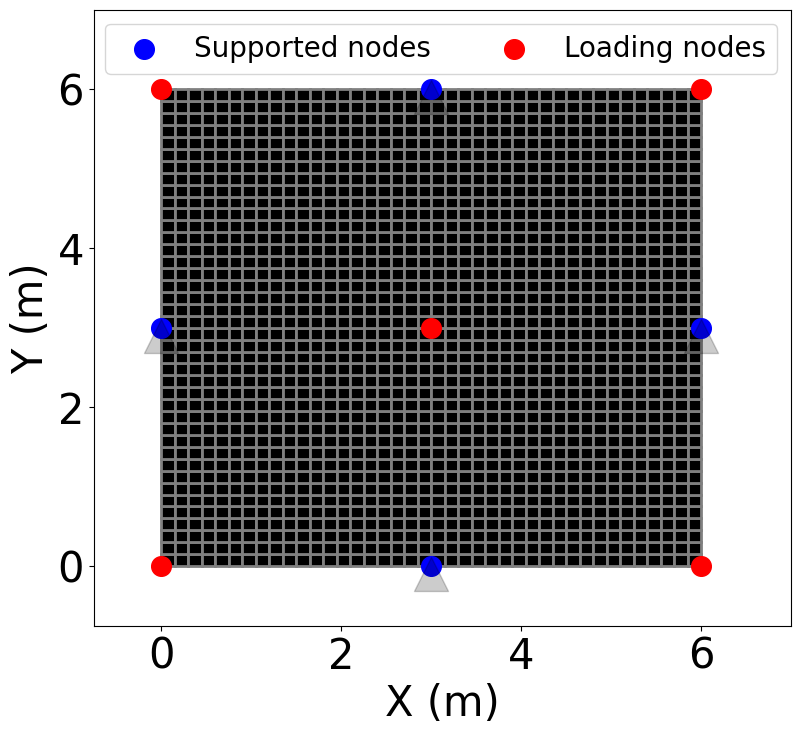

In [5]:
fig,ax = plt.subplots(figsize=(9,8))
ax.set_ylim(-0.75,7)
ax.set_xlim(-0.75,7)
#plt.title('{}-th iteration'.format(i))
plt.xlabel('X (m)',fontsize=30)
plt.ylabel('Y (m)',fontsize=30)
#ax = fig.add_subplot#(projection='3d')
#ax.set_zlim(0,20)
#ax.set_xlabel('X (m)',fontsize=15)
#ax.set_ylabel('Y (m)',fontsize=15)
#ax.set_zlabel('Z (m)',fontsize=15)
all_corners= []
import matplotlib as mpl
cmap = mpl.colormaps['binary']
for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    this_poly = Polygon([(xs[inode],ys[inode]), (xs[jnode],ys[jnode]), (xs[mnode],ys[mnode]),(xs[nnode],ys[nnode]),])
    alpha = float(1)
    #cthis_poly.set_alpha(alpha)
    this_poly.set_facecolor(cmap(alpha))
    this_poly.set_edgecolor('grey')
    this_poly.set_lw(2)
    ax.add_patch(this_poly)

ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=30)
#Plot a basic wireframe.
#for i in range(n_ele_bar):
##  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],color='darkcyan')

ax.scatter(xs[non_design_nodes],ys[non_design_nodes],color='blue',s=200,label='Supported nodes')
ax.scatter(xs[loading_nodes],ys[loading_nodes],color='red',s=200,label='Loading nodes')
ax.scatter(xs[non_design_nodes],ys[non_design_nodes]-0.1,s=600,marker='^',alpha=0.2,color='black')


#cb = plt.colorbar(mpl.cm.ScalarMappable( cmap=cmap), ax=ax)
#cb.ax.tick_params(labelsize=20)
plt.legend(fontsize=20,ncol=2)# loc=(0.5,0.7))
ax.grid(False)
plt.show()

In [6]:
def Linear_filter(dist,R):
    '''
    A linear filter with radius R, will be normalized later to satisfy unit-intergral condition.
    '''
    return np.where(dist>R,0,(1/R)*(R-dist))

r = 1.5 #Radius

Mapping for nodal distance filter

In [7]:
#Matrix storing XY-projected distance  
dx_ij = xs[:,None]-xs[None,:]
dy_ij = ys[:,None]-ys[None,:]
D_ij = (dx_ij**2 + dy_ij**2)**0.5

#Create the filter mapping matrix
B_ij_ini = Linear_filter(D_ij,r)
B_ij_sum = np.sum(B_ij_ini,axis=1)
B_ij_sum = B_ij_sum.repeat(xs.shape[0]).reshape(xs.shape[0],xs.shape[0])
B_ij = B_ij_ini/B_ij_sum

In [8]:
zs_filtered = zs.copy()
zs_filtered[design_nodes] =(B_ij@zs_filtered)[design_nodes]

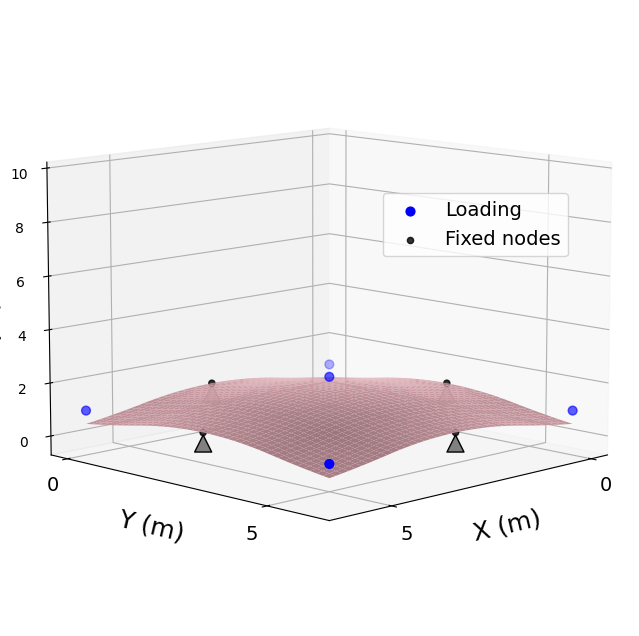

In [9]:
col = n_col+1
row = n_row+1 
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')
X = xs.reshape((row,col))
Y = ys.reshape((row,col))
Z = zs_filtered.reshape((row,col))
ax.set_xlabel('X (m)',fontsize=18)
ax.set_ylabel('Y (m)',fontsize=18)
ax.set_zlabel('Z (m)',fontsize=18)
plt.yticks([0,5,10,15,20],fontsize=14)
plt.xticks([0,5,10,15,20],fontsize=14)

ax.set_zlim(-0.5, 20)
ax.set_zlim(-0.5, 20)
ax.set_zlim(-0.5, 10)
ax.plot_surface(X, Y, Z, color='pink')#cmap=plt.cm.YlGnBu_r) 
ax.scatter(xs[loading_nodes],ys[loading_nodes],zs_filtered[loading_nodes]+0.5,color='blue',label='Loading',s=40)
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs_filtered[non_design_nodes],color='black',alpha=0.8,label='Fixed nodes',s=20)
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs_filtered[non_design_nodes]-0.4, s=150, facecolors='grey', edgecolors='black',marker='^')
ax.view_init(10, 45)
plt.legend(loc=(0.6,0.6),fontsize=14)

Mapping for shell-center distance filter

In [10]:
xs_shell = np.average(xs[cnct],axis=1)
ys_shell = np.average(ys[cnct],axis=1)

In [11]:
#Matrix storing XY-projected distance  
dx_ij_shell = xs_shell[:,None]-xs_shell[None,:]
dy_ij_shell = ys_shell[:,None]-ys_shell[None,:]
D_ij_shell = (dx_ij_shell**2 + dy_ij_shell**2)**0.5

#Create the filter mapping matrix
B_ij_ini_shell = Linear_filter(D_ij_shell,0.25)
B_ij_sum_shell = np.sum(B_ij_ini_shell,axis=1)
B_ij_sum_shell = B_ij_sum_shell.repeat(xs_shell.shape[0]).reshape(xs_shell.shape[0],xs_shell.shape[0])
B_ij_shell = B_ij_ini_shell/B_ij_sum_shell

In [12]:
B_ij_shell.shape

(1600, 1600)

In [13]:
#W(A): total volume
def coeff_E(mu,p=7):
    '''
    SIMP: modified stiffness with penalty
    mu is vector representing shell element's density ratio, between 0 and 1.
    E= mu^p * E_0 (p is the penalty factor and it is taken as 5)
    ''' 
    global E
    return mu**p*E

def coeff_E2(mu):
    '''
    SIMP: modified stiffness with penalty
    mu is vector representing shell element's density ratio, between 0 and 1.
    E= mu^p * E_0 (p is the penalty factor and it is taken as 5)
    ''' 
    global E
    return mu**2*E


def og_p(p_norm):
    '''
    Return the un-normalized p
    '''
    p_max = 3
    p_min = 0
    return (p_max-p_min)*p_norm+p_min

def norm_p(p):
    p_max = 3
    p_min = 0
    return  (p-p_min)/(p_max-p_min)


def plt_plan(mu_opt_filtered,i=0):
    fig,ax = plt.subplots(figsize=(11,10))
    ax.set_ylim(-2,8)
    ax.set_xlim(-2,8)
    #plt.title('{}-th iteration'.format(i))
    plt.xlabel('X (m)',fontsize=30)
    plt.ylabel('Y (m)',fontsize=30)
    #ax = fig.add_subplot#(projection='3d')
    #ax.set_zlim(0,20)
    #ax.set_xlabel('X (m)',fontsize=15)
    #ax.set_ylabel('Y (m)',fontsize=15)
    #ax.set_zlabel('Z (m)',fontsize=15)
    all_corners= []
    import matplotlib as mpl
    cmap = mpl.colormaps['binary']
    for i in range(n_ele):
        inode = cnct[i,0]
        jnode = cnct[i,1]
        mnode = cnct[i,2]
        nnode = cnct[i,3]
        this_poly = Polygon([(xs[inode],ys[inode]), (xs[jnode],ys[jnode]), (xs[mnode],ys[mnode]),(xs[nnode],ys[nnode]),])
        alpha = float(mu_opt_filtered[i])
        #cthis_poly.set_alpha(alpha)
        this_poly.set_facecolor(cmap(alpha))
        this_poly.set_edgecolor('black')
        this_poly.set_lw(2)
        ax.add_patch(this_poly)

    ax.tick_params(axis='both', which='major', labelsize=30)
    ax.tick_params(axis='both', which='minor', labelsize=30)
    #Plot a basic wireframe.
    #for i in range(n_ele_bar):
    ##  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],color='darkcyan')

    ax.scatter(xs[non_design_nodes],ys[non_design_nodes],color='black',label='Non-design nodes')
    ax.scatter(xs[non_design_nodes],ys[non_design_nodes],s=150,marker='^',alpha=0.2,color='black')


    cb = plt.colorbar(mpl.cm.ScalarMappable( cmap=cmap), ax=ax)
    cb.ax.tick_params(labelsize=20)
    plt.legend(fontsize=20)# loc=(0.5,0.7))
    ax.grid(False)
    plt.show()

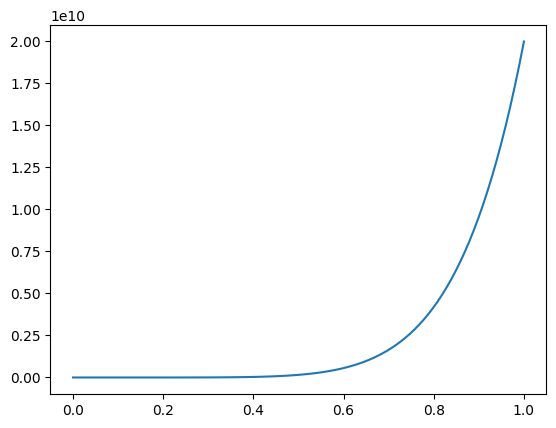

In [14]:
plt.plot(np.linspace(0,1,100),coeff_E(np.linspace(0,1,100)))

In [15]:
#%%
#Create model
model = Model.Model() #model for sensitivity analysis

#Adding nodes and boundary conditions
for i in range(n_node):
    model.add_node(i,xs[i],ys[i],zs_filtered[i])
    if i in non_design_nodes:
        model.add_support(i,[1,1,1,0,0,0]) #Pinned, only Ry allow
    if i in loading_nodes:
        model.add_nodal_load(i,nodal_load=[0.0,0.0,-Q,0.0,0.0,0.0])

#Adding elements
for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    model.add_quad(i,inode, jnode, mnode, nnode, 
                t, E, nu)

model.model_ready()




In [16]:
model.solve()

In [17]:
# Start the SSO model
sso_model = SSO_model(model) # initial sso model


#Nodal parameter: for shape optimization
for node in design_nodes:
    nodeparameter = NodeParameter(node,2) # nodeparamter object
    sso_model.add_nodeparameter(nodeparameter)

#Element parameter: 
for eletag in range(n_ele):
    eleparameter = ElementParameter(eletag,ele_type = 1,prop_type = 1) # element object, quad's young's modulus
    sso_model.add_eleparameter(eleparameter)


#Initial the parameters
sso_model.initialize_parameters_values()
sso_model.set_objective(objective='strain energy',func=None,func_args=None)

# NN

1. Input of NN: 
* XY of nodes

2. Outoput:
* Z
* Density ?


In [18]:
import pymesh
from flax import linen as nn

In [19]:
class SimpleNN(nn.Module):
    num_hidden : int   # Number of hidden neurons
    num_outputs : int  # Number of output neurons
    num_layers: int #Number of hidden layers

    @nn.compact  # Tells Flax to look for defined submodules
    def __call__(self, x):
        # Perform the calculation of the model to determine the prediction
        for i in range(self.num_layers):
            x = nn.Dense(features=self.num_hidden)(x)
            #x = nn.BatchNorm(use_running_average=not train)(x)
            x = nn.relu(x)
        x = nn.Dense(features=self.num_outputs)(x)
        x = nn.sigmoid(x) #Between 0 and 1
        return x

In [20]:
n_input = 2 #(X,Y) of each node
n_hidden = 40 # neurons
n_out = 2 #Z of each node & density
n_layers =3 #number of hidden layers

rng = jax.random.PRNGKey(42)

inp = np.abs(np.array([(xs-x_span/2)/np.max(xs),(ys-y_span/2)/np.max(ys)]).T)#,v_cen
#rng, inp_rng, init_rng = jax.random.split(rng, 3)

In [21]:
NN = SimpleNN(n_hidden,n_out,n_layers)

In [22]:
rng, init_rng = jax.random.split(rng, 2)
rng, init_rng = jax.random.split(rng, 2)
# Initialize the model
params = NN.init(init_rng, inp)

In [23]:
import optax
optimizer = optax.adam(learning_rate=0.02)

In [24]:
from flax.training import train_state

model_state = train_state.TrainState.create(apply_fn=NN.apply,
                                            params=params,
                                            tx=optimizer)

In [25]:
def calculate_loss(state, params, inp,alpha=0.1, p_E=2):


    ##Apply_fn: ML input to output
    outs = state.apply_fn(params, inp) #shape (n_node,2)
    node_params = outs[:,0]
    node_rho_params = outs[:,1]
    
    #1. NN outputs to update shape (nodal-Z coordinate)
    p = jnp.array(zs).copy()
    p = p.at[design_nodes].set(og_p(node_params)) #Unnormalized Control pt
    z = (B_ij@p)[design_nodes] #filtered actual geometry pt
    
    #sso_model.update_nodeparameter(z) # Update the model, this step causes "leak".... try directly call sso's function.
    
    #2. NN outputs to update topology (density, NN output is per-node density, average for each shell)
    ele_params = jnp.average(node_rho_params[cnct],axis=1) #Average per-node density for each shell
    filtered_mu = B_ij_shell@ele_params
    E_step = coeff_E(filtered_mu,p_E) #Penalized Young's modulus
    #sso_model.update_eleparameter(E_step) # Update the model
    
    #3. Loss function: penalized compliance
    parameter_values = jnp.hstack([z,E_step])
    compliance = sso_model.helper_params_to_objective(parameter_values,which_solver='sparse',enforce_scipy_sparse=True)
    # loss = compliance (normalized) + alpha *(volume/exp_volume -1)^2
    loss1 = compliance/40
    loss2 = alpha*(jnp.sum(filtered_mu)/(0.5*sso_model.eleparameters_values.shape[0])-1)**2
    loss =  loss1 + loss2
    return loss#loss1,loss2,z,filtered_mu

In [26]:
calculate_loss(model_state,params,inp)

Array(9.58721722, dtype=float64)

In [27]:
grad_fn = jax.value_and_grad(calculate_loss,  # Function to calculate the loss
                                 argnums=1,  # Parameters are second argument of the function
                                 has_aux=False  # Function has additional outputs, here accuracy
                                )
    # Determine gradients for current model, parameters and batch
loss, grads = grad_fn(model_state, model_state.params, inp)

In [28]:
@jax.jit  # Jit the function for efficiency
def train_step(state, inp,alpha=0.1, p=2):
    # Gradient function
    grad_fn = jax.value_and_grad(calculate_loss,  # Function to calculate the loss
                                 argnums=1,  # Parameters are second argument of the function
                                 has_aux=False  # Function has additional outputs, here accuracy
                                )
    # Determine gradients for current model, parameters and batch
    loss, grads = grad_fn(state, state.params, inp,alpha, p)
    # Perform parameter update with gradients and optimizer
    state = state.apply_gradients(grads=grads)
    # Return state and any other value we might want
    return state, loss

In [29]:
%timeit train_step(model_state, inp)

2.67 s ± 11.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
metrics_history = {'train_loss': []}
from tqdm import tqdm
loss_list =[]
def train_model(state, num_epochs=200):
    alpha = 0.1
    p = 2
    # Training loop
    for epoch in tqdm(range(num_epochs)):
        
        if alpha < 100:
            alpha = 0.1 +len(loss_list) * 0.05
        if p<8:
            p = 2 + 0.06*len(loss_list)
        print('Iter{}, alpha={}, p={}'.format(len(loss_list),alpha,p))
        state, loss = train_step(state, inp,alpha,p)
        metrics_history['train_loss'].append(loss)
        print('Train epoch {}'.format(len(metrics_history['train_loss'])+1)+'  ,loss:{}'.format(loss))
        # We could use the loss and accuracy for logging here, e.g. in TensorBoard
        # For simplicity, we skip this part here
        loss_list.append(loss)
        if len(loss_list)%5==0:
            i = len(loss_list)
            
            outs = state.apply_fn(state.params, inp) #shape (n_node,2)
            node_params = outs[:,0]
            node_rho_params = outs[:,1]



            #sso_model.update_nodeparameter(z) # Update the model, this step causes "leak".... try directly call sso's function.

            #2. NN outputs to update topology (density, NN output is per-node density, average for each shell)
            ele_params = jnp.average(node_rho_params[cnct],axis=1) #Average per-node density for each shell
            filtered_mu = B_ij_shell@ele_params
            E_step = coeff_E(filtered_mu) #Penalized Young's modulus
            print(jnp.sum(ele_params))
            
            plt_plan(filtered_mu,i)
    return state

  0%|          | 0/205 [00:00<?, ?it/s]

Iter0, alpha=0.1, p=2.0


  0%|          | 1/205 [00:37<2:06:23, 37.17s/it]

Train epoch 2  ,loss:9.587217224624494
Iter1, alpha=0.15000000000000002, p=2.06


  1%|          | 2/205 [00:39<57:12, 16.91s/it]  

Train epoch 3  ,loss:3.057053746851415
Iter2, alpha=0.2, p=2.12


  1%|▏         | 3/205 [00:42<35:06, 10.43s/it]

Train epoch 4  ,loss:2.1887962297839443
Iter3, alpha=0.25, p=2.18


  2%|▏         | 4/205 [00:45<24:42,  7.38s/it]

Train epoch 5  ,loss:1.448812160763882
Iter4, alpha=0.30000000000000004, p=2.24
Train epoch 6  ,loss:1.010596634264518
1209.0072051707148


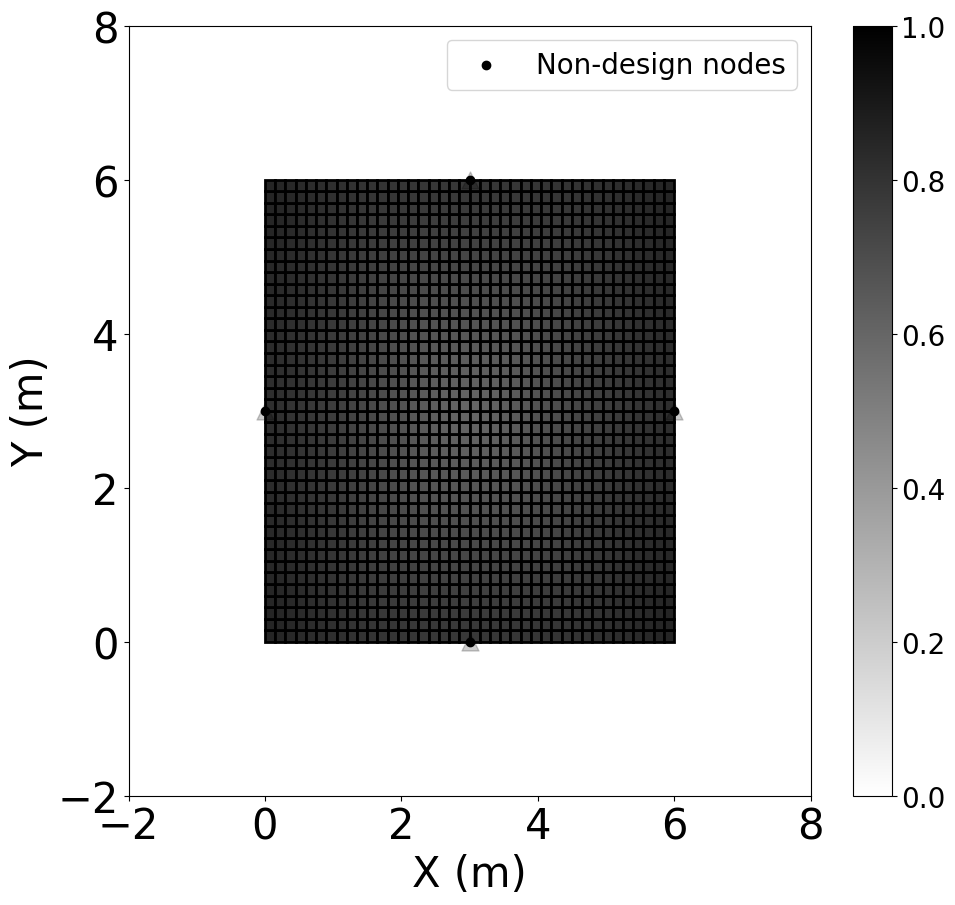

  2%|▏         | 5/205 [00:49<20:38,  6.19s/it]

Iter5, alpha=0.35, p=2.3


  3%|▎         | 6/205 [00:52<16:36,  5.01s/it]

Train epoch 7  ,loss:0.7605145682172828
Iter6, alpha=0.4, p=2.36


  3%|▎         | 7/205 [00:54<14:03,  4.26s/it]

Train epoch 8  ,loss:0.6488131973410128
Iter7, alpha=0.45000000000000007, p=2.42


  4%|▍         | 8/205 [00:57<12:22,  3.77s/it]

Train epoch 9  ,loss:0.6143499918263657
Iter8, alpha=0.5, p=2.48


  4%|▍         | 9/205 [01:00<11:13,  3.44s/it]

Train epoch 10  ,loss:0.6229237402343858
Iter9, alpha=0.55, p=2.54
Train epoch 11  ,loss:0.6543055284131164
1478.6016874927686


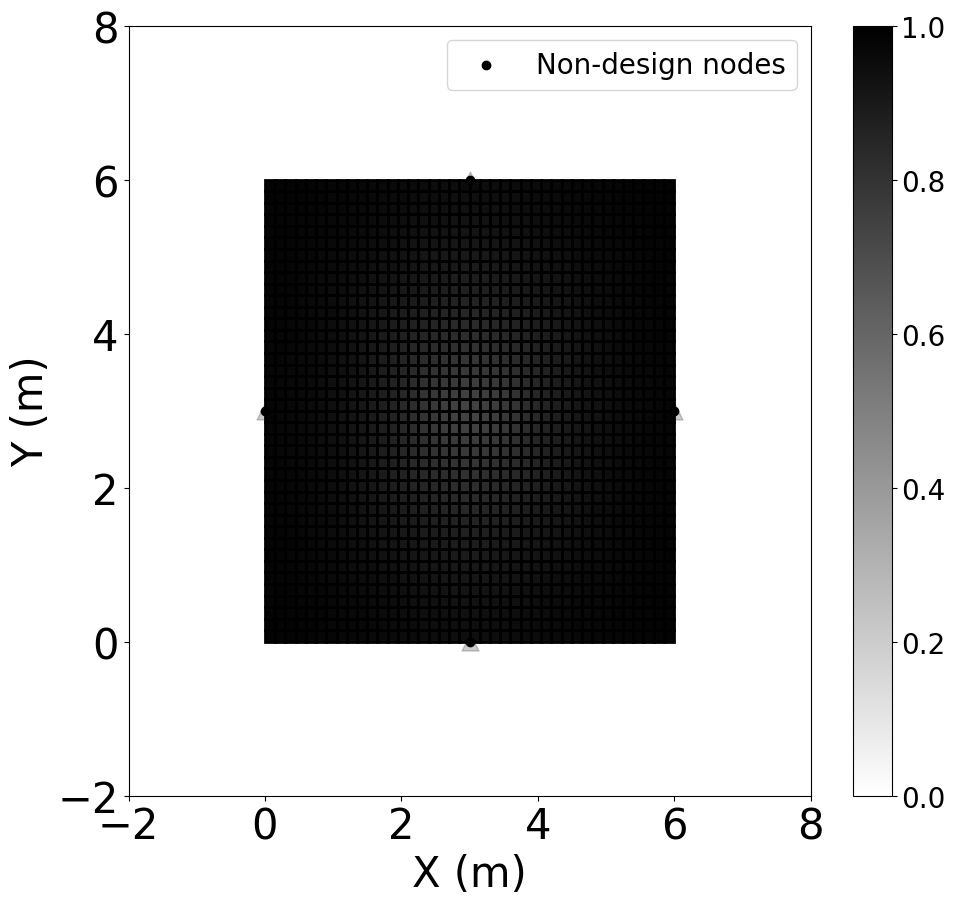

  5%|▍         | 10/205 [01:04<11:59,  3.69s/it]

Iter10, alpha=0.6, p=2.6


  5%|▌         | 11/205 [01:07<10:57,  3.39s/it]

Train epoch 12  ,loss:0.6938839926470763
Iter11, alpha=0.65, p=2.66


  6%|▌         | 12/205 [01:09<10:14,  3.18s/it]

Train epoch 13  ,loss:0.7372924065714771
Iter12, alpha=0.7000000000000001, p=2.7199999999999998


  6%|▋         | 13/205 [01:12<09:43,  3.04s/it]

Train epoch 14  ,loss:0.781717747026563
Iter13, alpha=0.75, p=2.7800000000000002


  7%|▋         | 14/205 [01:15<09:21,  2.94s/it]

Train epoch 15  ,loss:0.8260994179684846
Iter14, alpha=0.8, p=2.84
Train epoch 16  ,loss:0.8693529957167311
1531.7078099505638


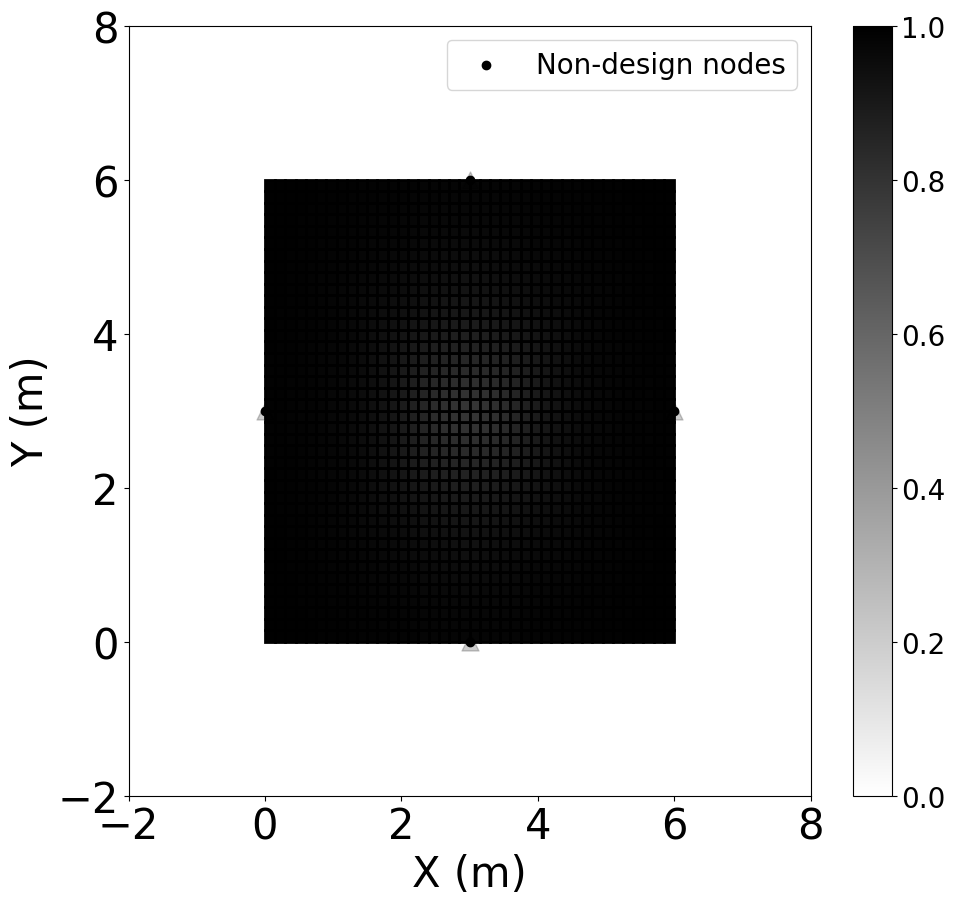

  7%|▋         | 15/205 [01:19<10:19,  3.26s/it]

Iter15, alpha=0.85, p=2.9


  8%|▊         | 16/205 [01:22<09:45,  3.10s/it]

Train epoch 17  ,loss:0.9110062544361864
Iter16, alpha=0.9, p=2.96


  8%|▊         | 17/205 [01:24<09:19,  2.98s/it]

Train epoch 18  ,loss:0.9502805388664848
Iter17, alpha=0.9500000000000001, p=3.02


  9%|▉         | 18/205 [01:27<09:00,  2.89s/it]

Train epoch 19  ,loss:0.986780805360514
Iter18, alpha=1.0, p=3.08


  9%|▉         | 19/205 [01:30<08:47,  2.83s/it]

Train epoch 20  ,loss:1.0202346529469428
Iter19, alpha=1.05, p=3.1399999999999997
Train epoch 21  ,loss:1.0499000352342063
1526.3982624115743


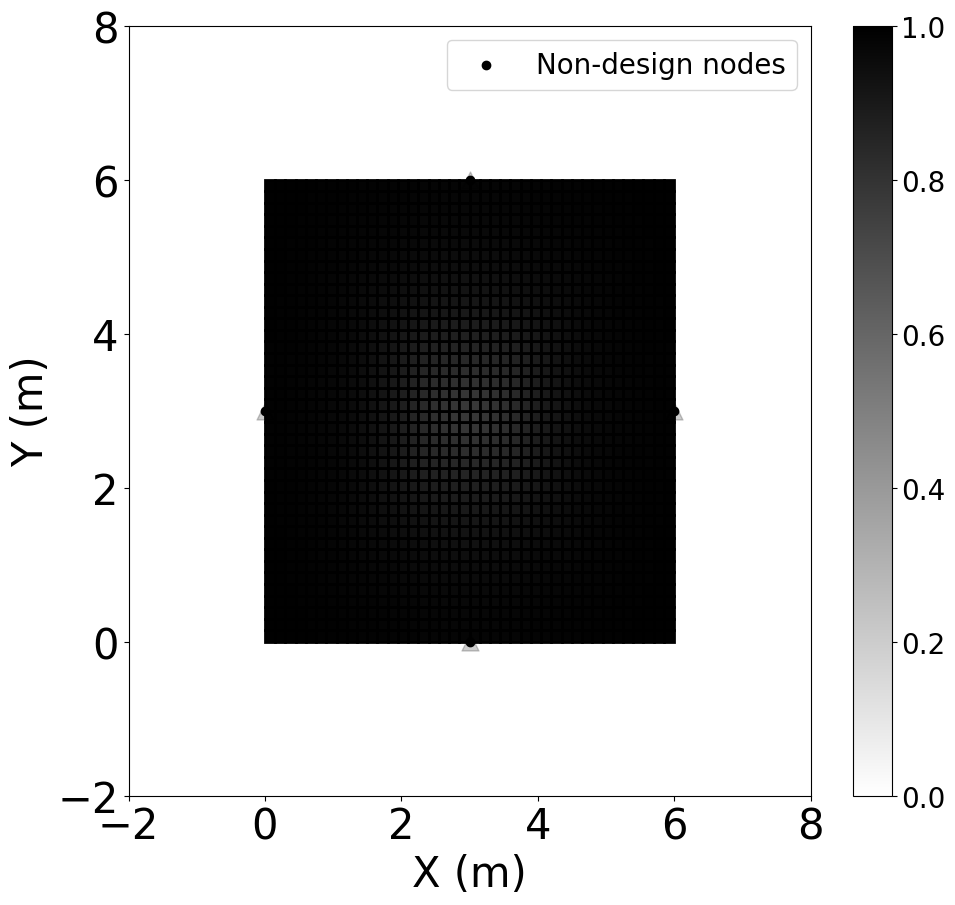

 10%|▉         | 20/205 [01:34<10:04,  3.27s/it]

Iter20, alpha=1.1, p=3.2


 10%|█         | 21/205 [01:37<09:27,  3.09s/it]

Train epoch 22  ,loss:1.0745880224781081
Iter21, alpha=1.1500000000000001, p=3.26


 11%|█         | 22/205 [01:39<09:03,  2.97s/it]

Train epoch 23  ,loss:1.092563381010159
Iter22, alpha=1.2000000000000002, p=3.32


 11%|█         | 23/205 [01:42<08:43,  2.88s/it]

Train epoch 24  ,loss:1.1018383767229407
Iter23, alpha=1.2500000000000002, p=3.38


 12%|█▏        | 24/205 [01:45<08:29,  2.82s/it]

Train epoch 25  ,loss:1.1003291461217852
Iter24, alpha=1.3000000000000003, p=3.44
Train epoch 26  ,loss:1.0855213964280004
1449.245383767969


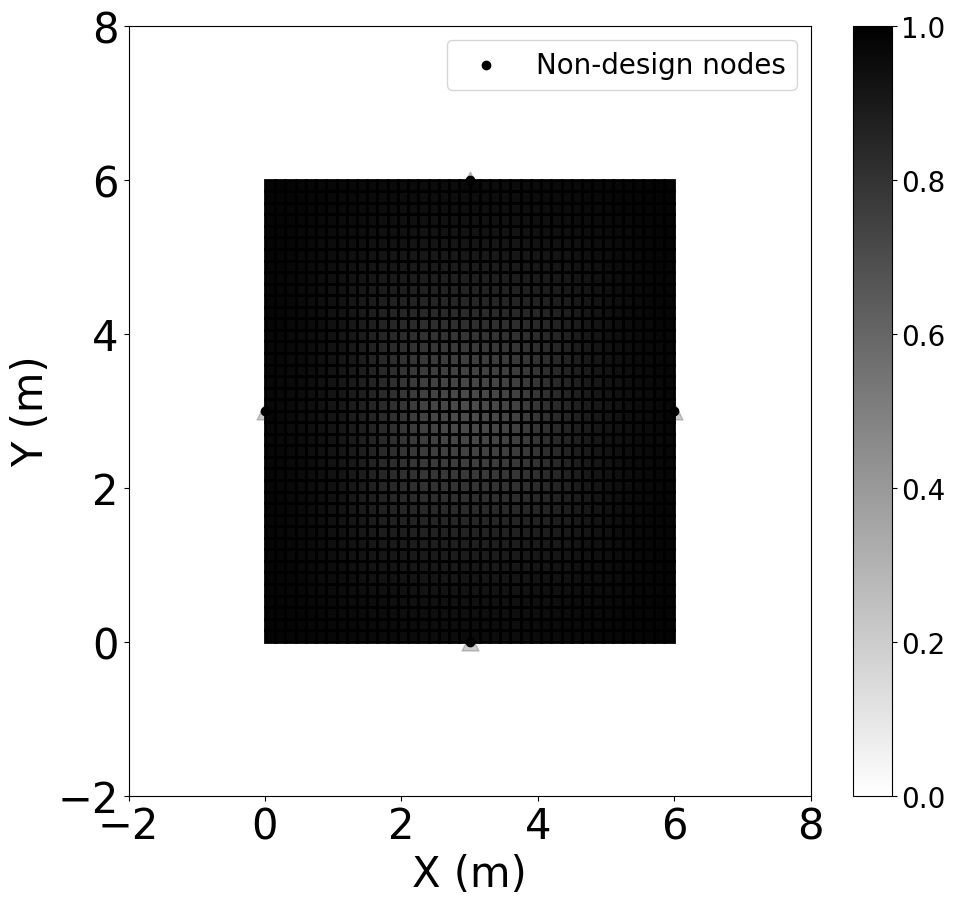

 12%|█▏        | 25/205 [01:49<09:29,  3.16s/it]

Iter25, alpha=1.35, p=3.5


 13%|█▎        | 26/205 [01:51<08:59,  3.02s/it]

Train epoch 27  ,loss:1.0516366714964414
Iter26, alpha=1.4000000000000001, p=3.56


 13%|█▎        | 27/205 [01:54<08:38,  2.91s/it]

Train epoch 28  ,loss:0.9932578421031573
Iter27, alpha=1.4500000000000002, p=3.62


 14%|█▎        | 28/205 [01:57<08:22,  2.84s/it]

Train epoch 29  ,loss:0.9071240552384572
Iter28, alpha=1.5000000000000002, p=3.6799999999999997


 14%|█▍        | 29/205 [01:59<08:10,  2.79s/it]

Train epoch 30  ,loss:0.795508663426702
Iter29, alpha=1.5500000000000003, p=3.74
Train epoch 31  ,loss:0.6828455073677894
1104.2355131472382


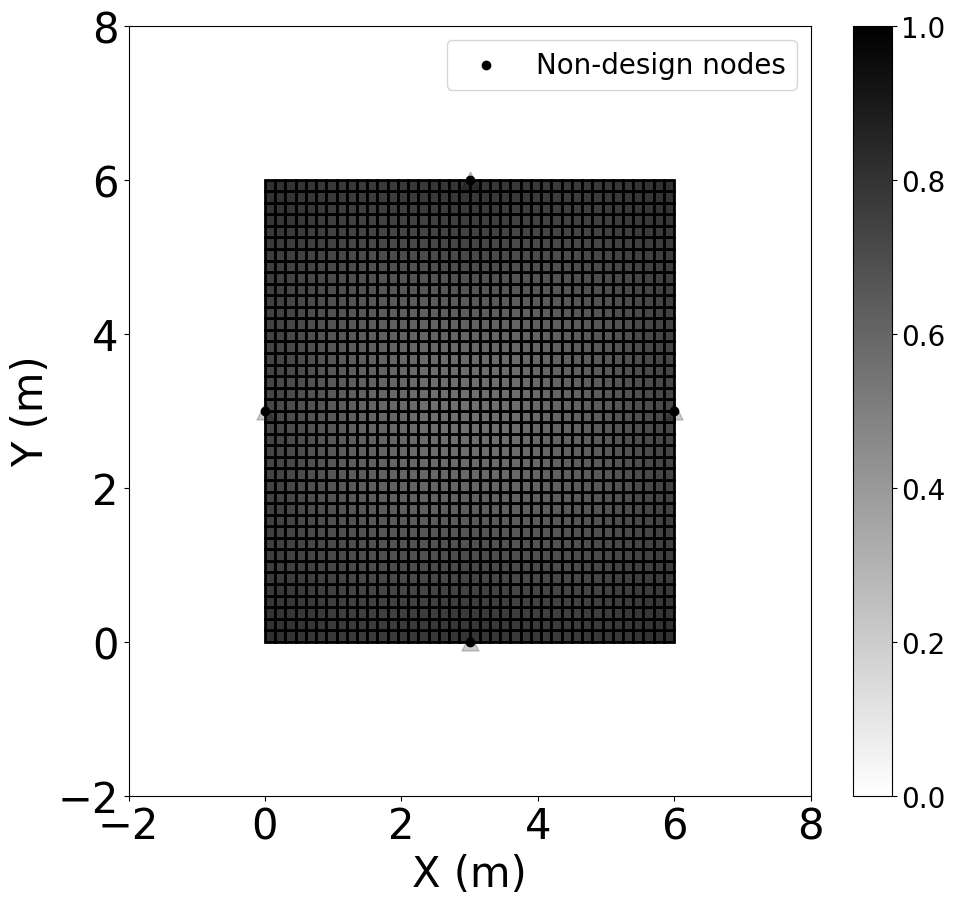

 15%|█▍        | 30/205 [02:04<09:23,  3.22s/it]

Iter30, alpha=1.6, p=3.8


 15%|█▌        | 31/205 [02:06<08:51,  3.05s/it]

Train epoch 32  ,loss:0.6214694899172396
Iter31, alpha=1.6500000000000001, p=3.86


 16%|█▌        | 32/205 [02:09<08:28,  2.94s/it]

Train epoch 33  ,loss:0.6744289995792303
Iter32, alpha=1.7000000000000002, p=3.92


 16%|█▌        | 33/205 [02:12<08:12,  2.86s/it]

Train epoch 34  ,loss:0.722366462763681
Iter33, alpha=1.7500000000000002, p=3.98


 17%|█▋        | 34/205 [02:14<07:59,  2.80s/it]

Train epoch 35  ,loss:0.6797954879528222
Iter34, alpha=1.8000000000000003, p=4.04
Train epoch 36  ,loss:0.6110505306044699
1029.0029905973383


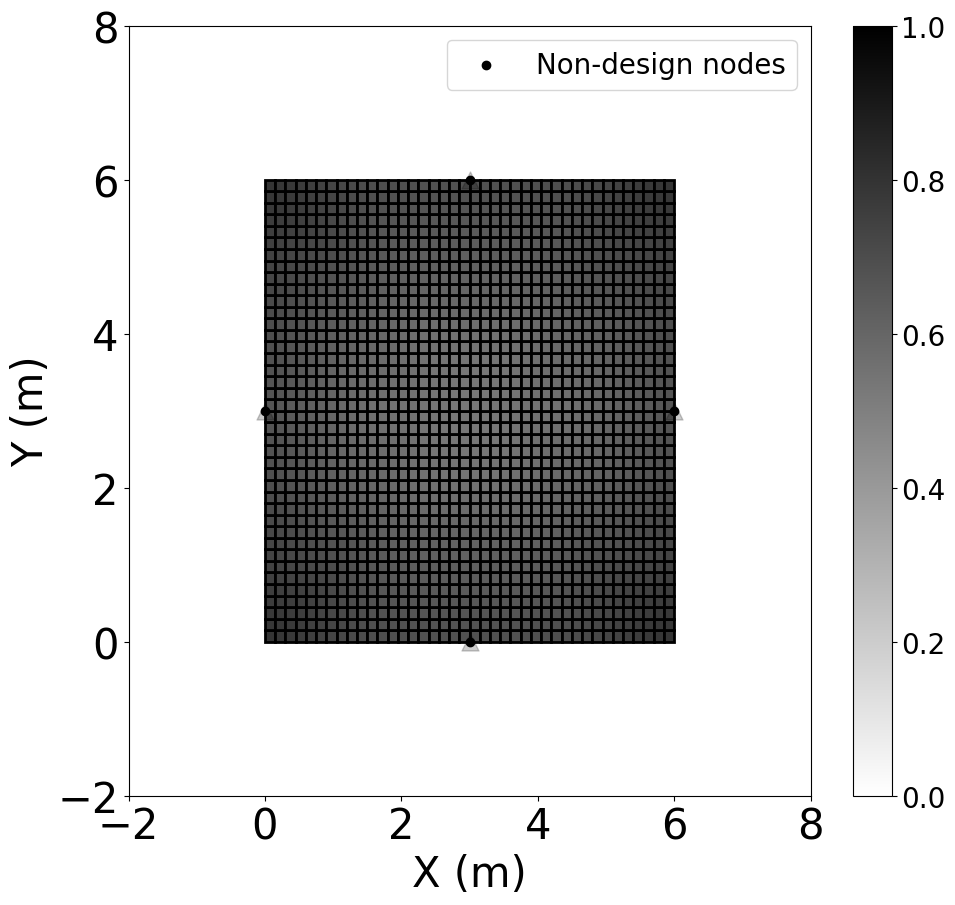

 17%|█▋        | 35/205 [02:18<08:57,  3.16s/it]

Iter35, alpha=1.85, p=4.1


 18%|█▊        | 36/205 [02:21<08:30,  3.02s/it]

Train epoch 37  ,loss:0.5668819001366373
Iter36, alpha=1.9000000000000001, p=4.16


 18%|█▊        | 37/205 [02:24<08:10,  2.92s/it]

Train epoch 38  ,loss:0.5512664173009053
Iter37, alpha=1.9500000000000002, p=4.22


 19%|█▊        | 38/205 [02:26<07:55,  2.84s/it]

Train epoch 39  ,loss:0.5456045154693744
Iter38, alpha=2.0, p=4.279999999999999


 19%|█▉        | 39/205 [02:29<07:43,  2.79s/it]

Train epoch 40  ,loss:0.5355645252758934
Iter39, alpha=2.0500000000000003, p=4.34
Train epoch 41  ,loss:0.5147891105000127
1061.3317372789397


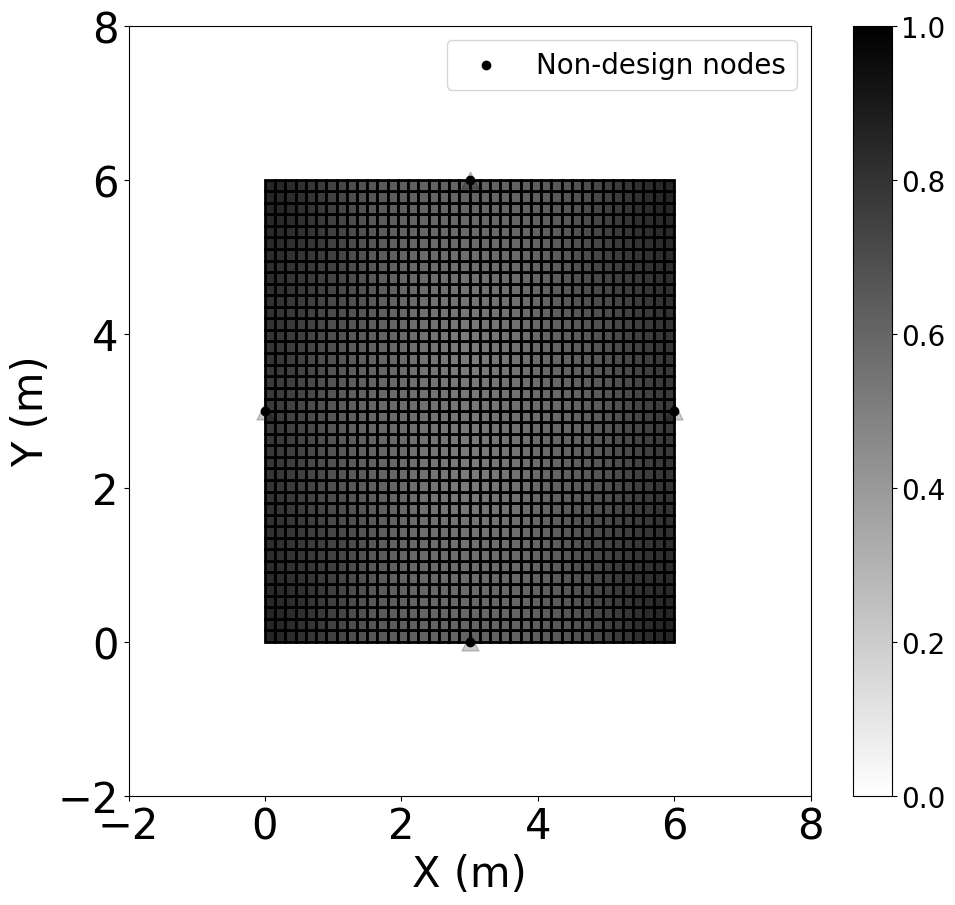

 20%|█▉        | 40/205 [02:33<08:52,  3.23s/it]

Iter40, alpha=2.1, p=4.4


 20%|██        | 41/205 [02:36<08:21,  3.06s/it]

Train epoch 42  ,loss:0.48265137598901453
Iter41, alpha=2.1500000000000004, p=4.46


 20%|██        | 42/205 [02:39<08:00,  2.95s/it]

Train epoch 43  ,loss:0.4440138177553797
Iter42, alpha=2.2, p=4.52


 21%|██        | 43/205 [02:41<07:44,  2.87s/it]

Train epoch 44  ,loss:0.41899134945944577
Iter43, alpha=2.25, p=4.58


 21%|██▏       | 44/205 [02:44<07:32,  2.81s/it]

Train epoch 45  ,loss:0.42057274223934127
Iter44, alpha=2.3000000000000003, p=4.64
Train epoch 46  ,loss:0.4195196304701723
919.29038351595


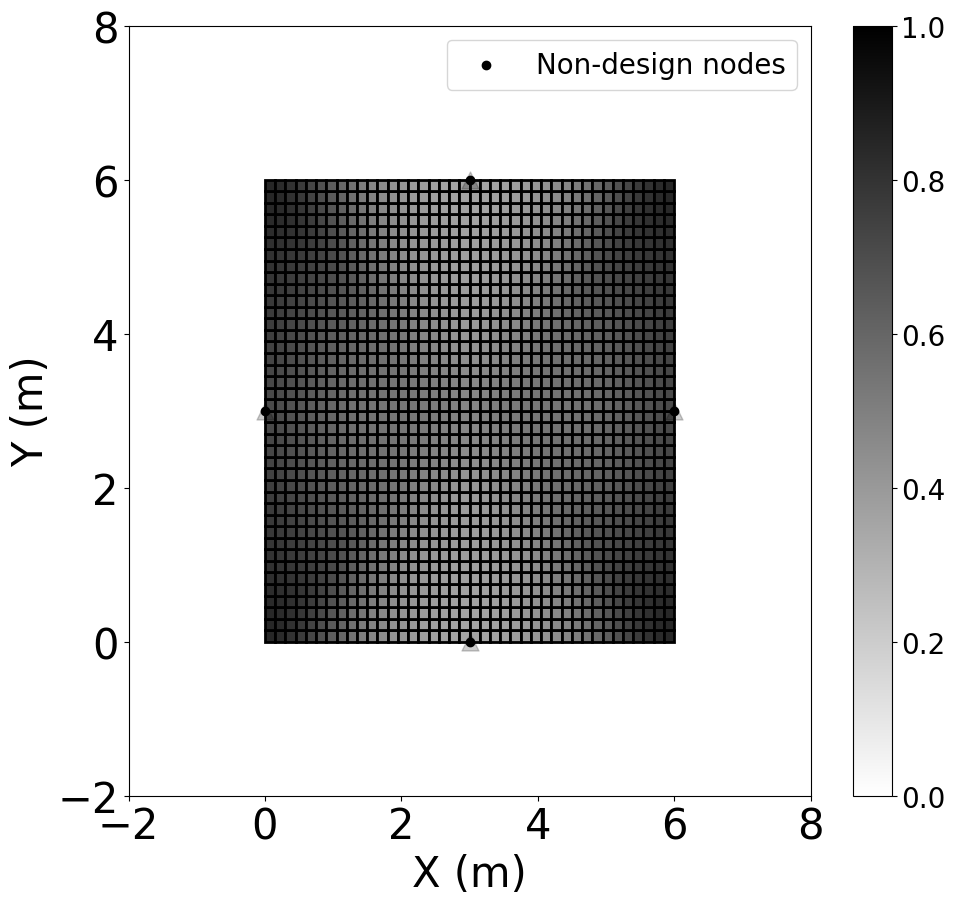

 22%|██▏       | 45/205 [02:48<08:27,  3.17s/it]

Iter45, alpha=2.35, p=4.699999999999999


 22%|██▏       | 46/205 [02:51<08:00,  3.02s/it]

Train epoch 47  ,loss:0.3904808001419636
Iter46, alpha=2.4000000000000004, p=4.76


 23%|██▎       | 47/205 [02:53<07:41,  2.92s/it]

Train epoch 48  ,loss:0.3592066309873847
Iter47, alpha=2.45, p=4.82


 23%|██▎       | 48/205 [02:56<07:28,  2.86s/it]

Train epoch 49  ,loss:0.3496683418716277
Iter48, alpha=2.5000000000000004, p=4.88


 24%|██▍       | 49/205 [02:59<07:16,  2.80s/it]

Train epoch 50  ,loss:0.3498820684850564
Iter49, alpha=2.5500000000000003, p=4.9399999999999995
Train epoch 51  ,loss:0.34903694509397126
949.4390142154832


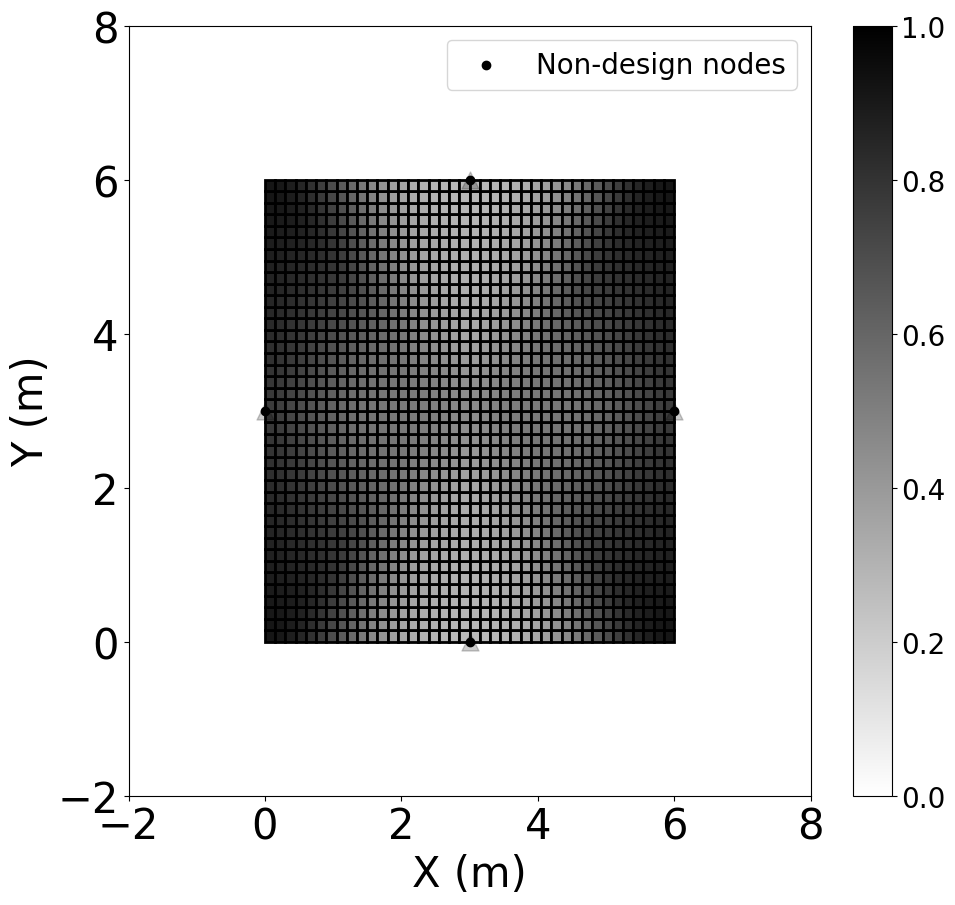

 24%|██▍       | 50/205 [03:03<08:20,  3.23s/it]

Iter50, alpha=2.6, p=5.0


 25%|██▍       | 51/205 [03:06<07:51,  3.06s/it]

Train epoch 52  ,loss:0.3426719836548922
Iter51, alpha=2.6500000000000004, p=5.0600000000000005


 25%|██▌       | 52/205 [03:08<07:30,  2.95s/it]

Train epoch 53  ,loss:0.33213329595740954
Iter52, alpha=2.7, p=5.12


 26%|██▌       | 53/205 [03:11<07:16,  2.87s/it]

Train epoch 54  ,loss:0.3232889037098559
Iter53, alpha=2.7500000000000004, p=5.18


 26%|██▋       | 54/205 [03:14<07:04,  2.81s/it]

Train epoch 55  ,loss:0.32134343906866725
Iter54, alpha=2.8000000000000003, p=5.24
Train epoch 56  ,loss:0.31519356401429327
902.9153143296339


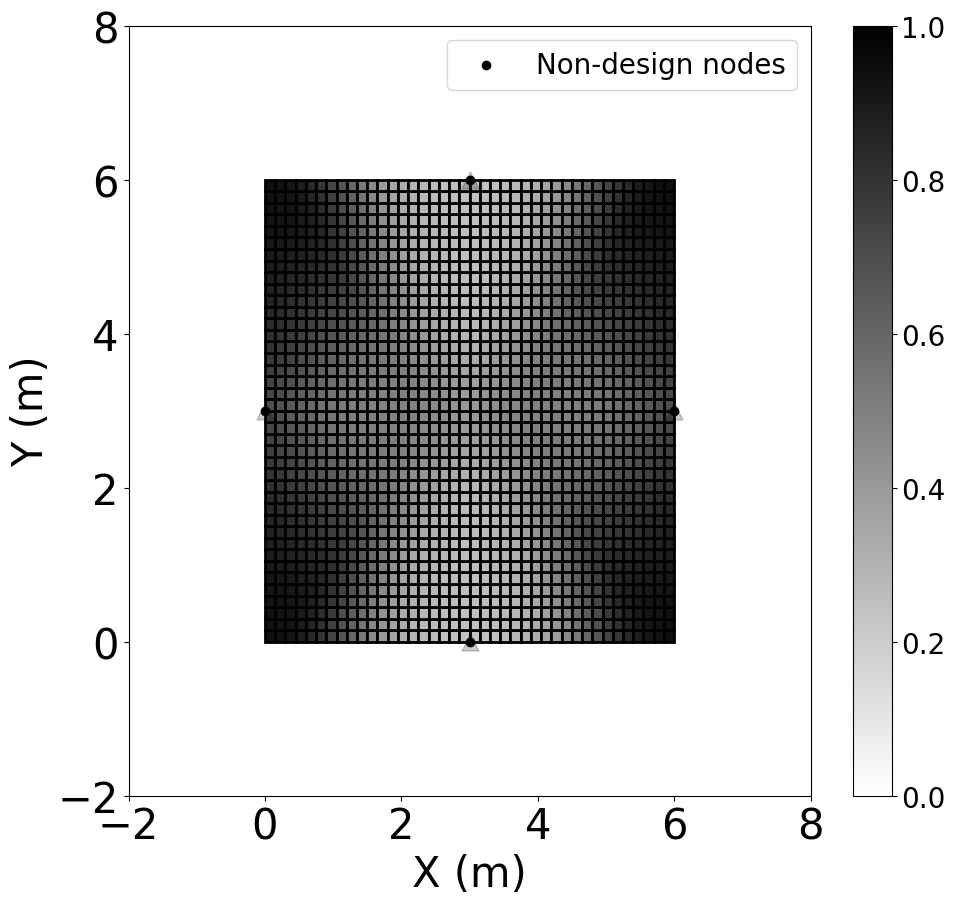

 27%|██▋       | 55/205 [03:18<07:55,  3.17s/it]

Iter55, alpha=2.85, p=5.3


 27%|██▋       | 56/205 [03:20<07:30,  3.02s/it]

Train epoch 57  ,loss:0.3033628210100366
Iter56, alpha=2.9000000000000004, p=5.359999999999999


 28%|██▊       | 57/205 [03:23<07:12,  2.92s/it]

Train epoch 58  ,loss:0.3016116633328509
Iter57, alpha=2.95, p=5.42


 28%|██▊       | 58/205 [03:26<06:58,  2.85s/it]

Train epoch 59  ,loss:0.30715473133001525
Iter58, alpha=3.0000000000000004, p=5.48


 29%|██▉       | 59/205 [03:28<06:48,  2.80s/it]

Train epoch 60  ,loss:0.3059443607277191
Iter59, alpha=3.0500000000000003, p=5.54
Train epoch 61  ,loss:0.29632611098967704
908.2619328026859


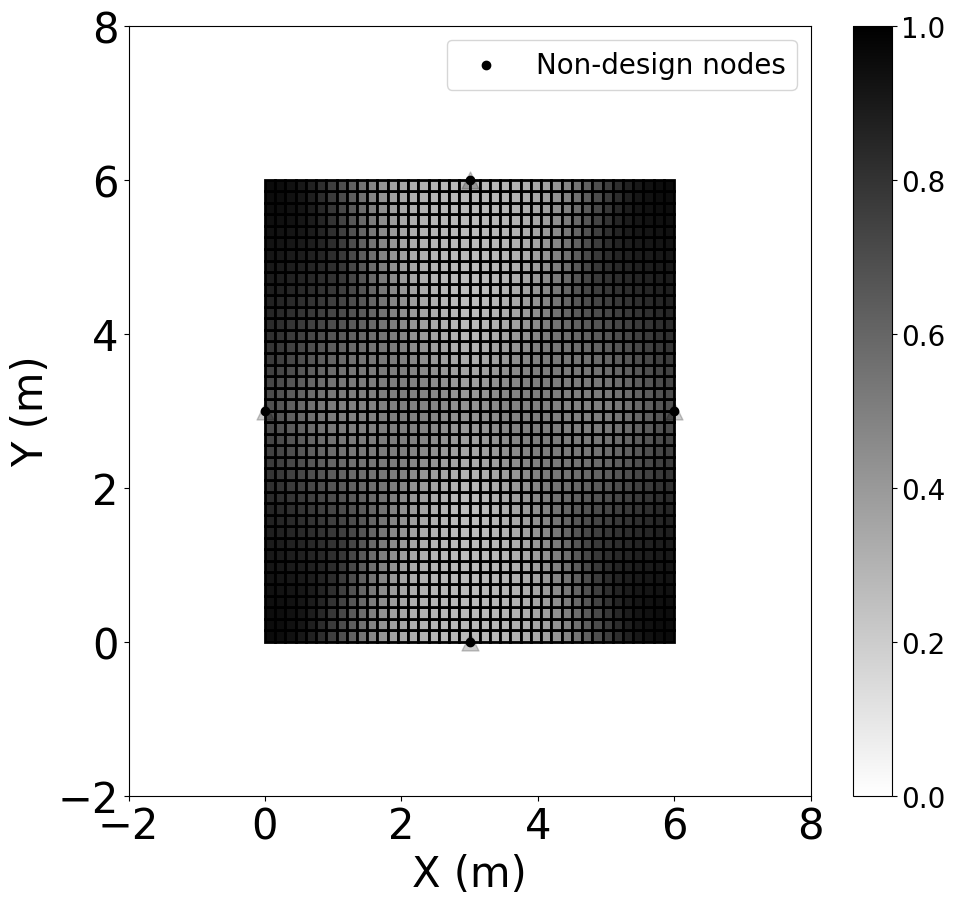

 29%|██▉       | 60/205 [03:33<07:49,  3.24s/it]

Iter60, alpha=3.1, p=5.6


 30%|██▉       | 61/205 [03:35<07:22,  3.07s/it]

Train epoch 62  ,loss:0.28984257164728056
Iter61, alpha=3.1500000000000004, p=5.66


 30%|███       | 62/205 [03:38<07:02,  2.96s/it]

Train epoch 63  ,loss:0.28833059746231676
Iter62, alpha=3.2, p=5.72


 31%|███       | 63/205 [03:41<06:48,  2.88s/it]

Train epoch 64  ,loss:0.28319388111684457
Iter63, alpha=3.2500000000000004, p=5.779999999999999


 31%|███       | 64/205 [03:43<06:37,  2.82s/it]

Train epoch 65  ,loss:0.27834686864737235
Iter64, alpha=3.3000000000000003, p=5.84
Train epoch 66  ,loss:0.2781285128887424
914.5624598485522


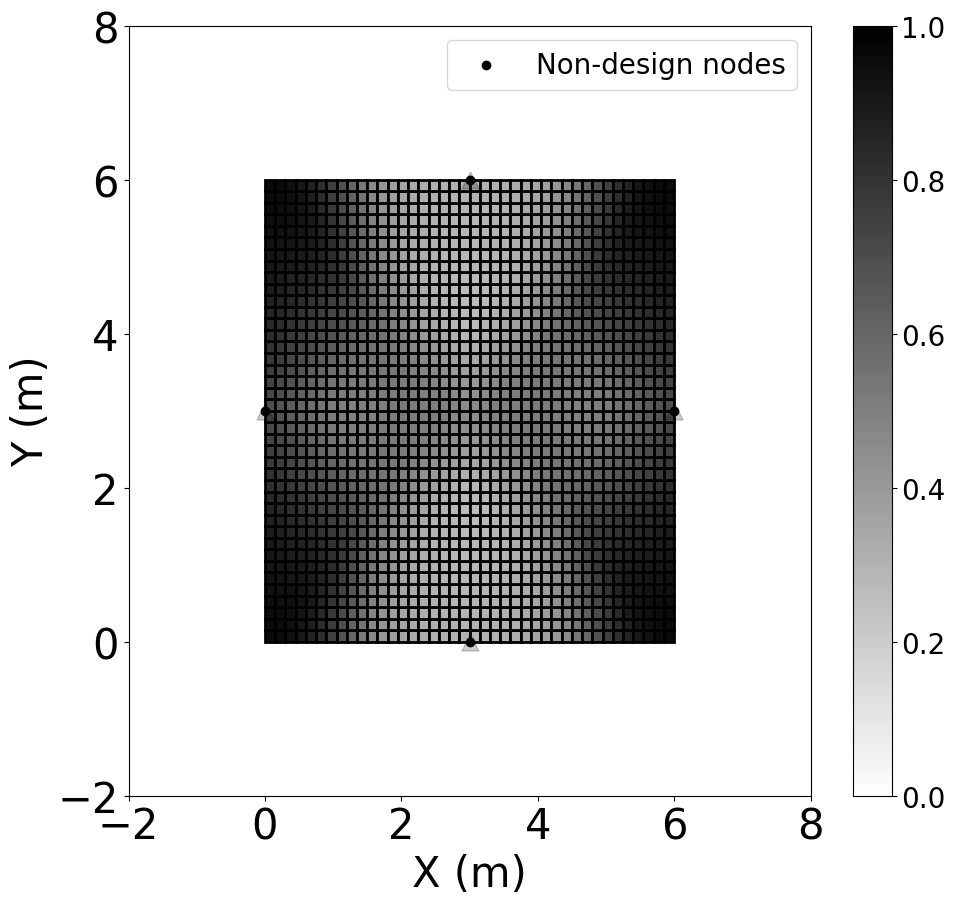

 32%|███▏      | 65/205 [03:47<07:24,  3.17s/it]

Iter65, alpha=3.35, p=5.9


 32%|███▏      | 66/205 [03:50<07:00,  3.03s/it]

Train epoch 67  ,loss:0.27695851981928415
Iter66, alpha=3.4000000000000004, p=5.96


 33%|███▎      | 67/205 [03:53<06:42,  2.92s/it]

Train epoch 68  ,loss:0.2718605748816856
Iter67, alpha=3.45, p=6.02


 33%|███▎      | 68/205 [03:55<06:30,  2.85s/it]

Train epoch 69  ,loss:0.26765129646717156
Iter68, alpha=3.5000000000000004, p=6.08


 34%|███▎      | 69/205 [03:58<06:20,  2.80s/it]

Train epoch 70  ,loss:0.2676339981107066
Iter69, alpha=3.5500000000000003, p=6.14
Train epoch 71  ,loss:0.26702180439321066
892.3088043870056


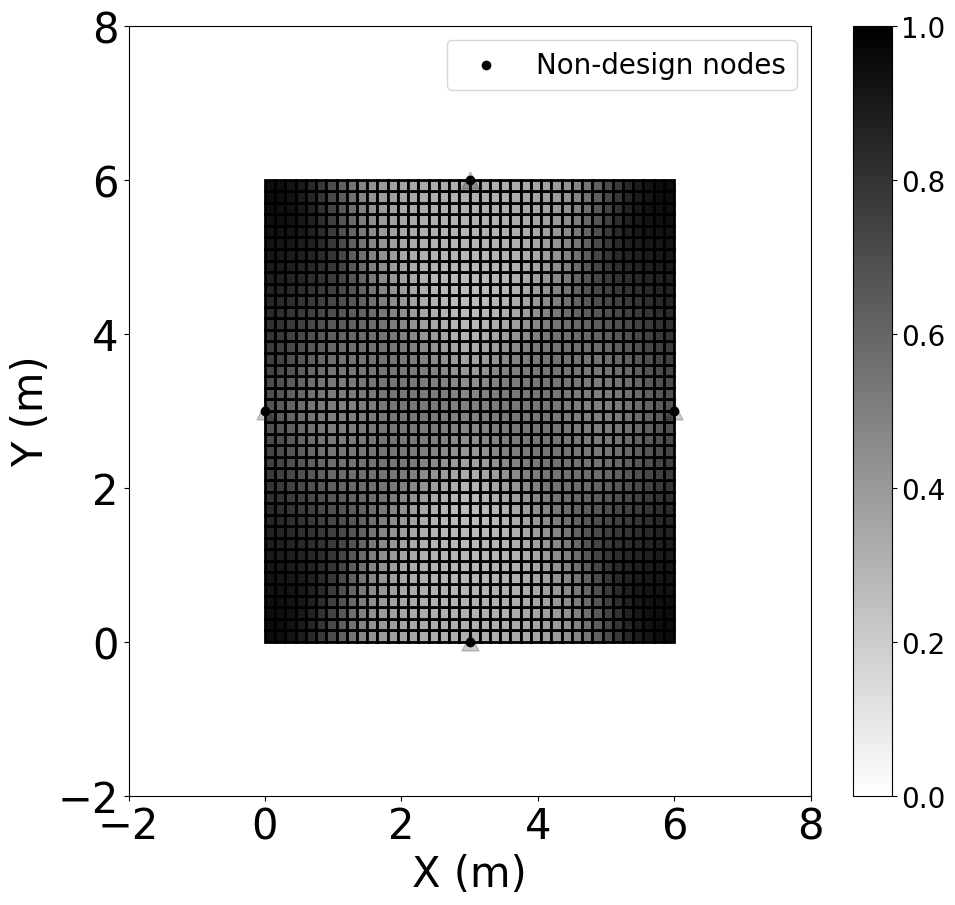

 34%|███▍      | 70/205 [04:02<07:15,  3.23s/it]

Iter70, alpha=3.6, p=6.2


 35%|███▍      | 71/205 [04:05<06:50,  3.06s/it]

Train epoch 72  ,loss:0.2647531128962564
Iter71, alpha=3.6500000000000004, p=6.26


 35%|███▌      | 72/205 [04:08<06:31,  2.95s/it]

Train epoch 73  ,loss:0.2648863205294714
Iter72, alpha=3.7, p=6.32


 36%|███▌      | 73/205 [04:10<06:18,  2.87s/it]

Train epoch 74  ,loss:0.2642854086310603
Iter73, alpha=3.7500000000000004, p=6.38


 36%|███▌      | 74/205 [04:13<06:07,  2.81s/it]

Train epoch 75  ,loss:0.2611694696013962
Iter74, alpha=3.8000000000000003, p=6.4399999999999995
Train epoch 76  ,loss:0.2596701825543911
870.3544983251618


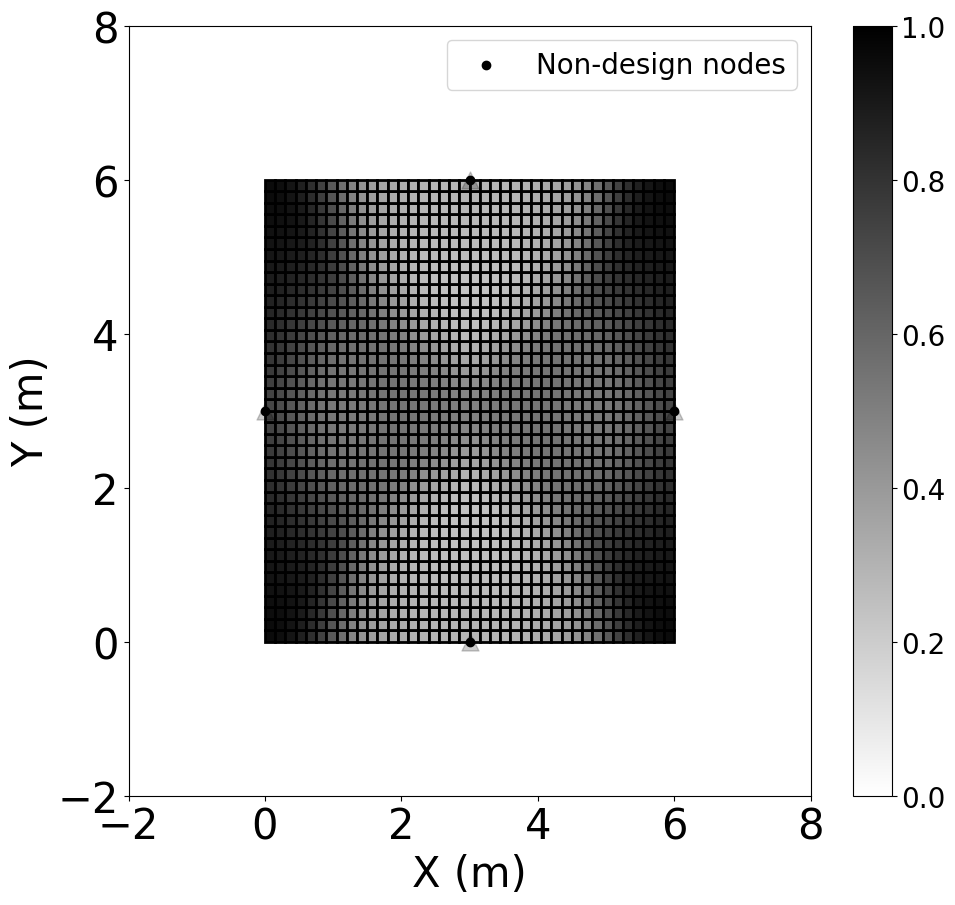

 37%|███▋      | 75/205 [04:17<06:51,  3.16s/it]

Iter75, alpha=3.85, p=6.5


 37%|███▋      | 76/205 [04:20<06:29,  3.02s/it]

Train epoch 77  ,loss:0.259986481054967
Iter76, alpha=3.9000000000000004, p=6.56


 38%|███▊      | 77/205 [04:22<06:13,  2.92s/it]

Train epoch 78  ,loss:0.2584262878343828
Iter77, alpha=3.95, p=6.62


 38%|███▊      | 78/205 [04:25<06:01,  2.84s/it]

Train epoch 79  ,loss:0.2564763090268287
Iter78, alpha=4.0, p=6.68


 39%|███▊      | 79/205 [04:28<05:52,  2.79s/it]

Train epoch 80  ,loss:0.2548365169485049
Iter79, alpha=4.05, p=6.74
Train epoch 81  ,loss:0.2507404689496178
869.9721421914066


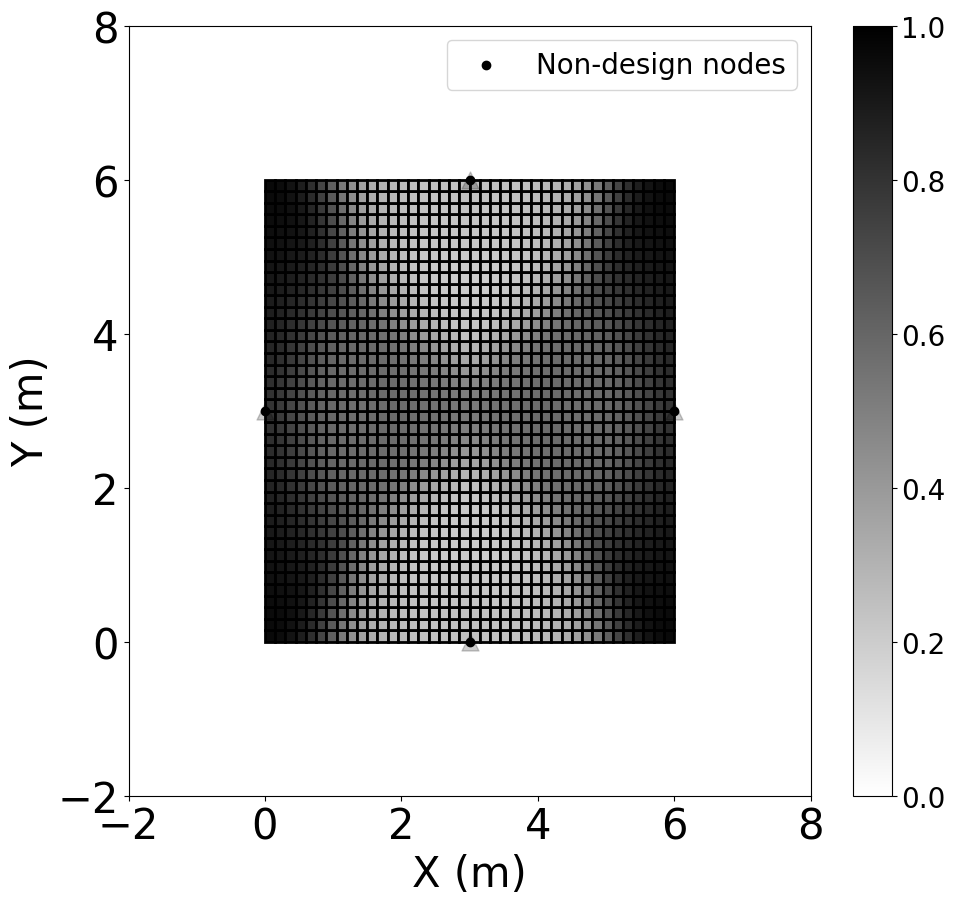

 39%|███▉      | 80/205 [04:32<06:43,  3.23s/it]

Iter80, alpha=4.1, p=6.8


 40%|███▉      | 81/205 [04:35<06:19,  3.06s/it]

Train epoch 82  ,loss:0.2439214052603215
Iter81, alpha=4.1499999999999995, p=6.859999999999999


 40%|████      | 82/205 [04:37<06:02,  2.95s/it]

Train epoch 83  ,loss:0.23661081756875232
Iter82, alpha=4.2, p=6.92


 40%|████      | 83/205 [04:40<05:50,  2.87s/it]

Train epoch 84  ,loss:0.22731026184229358
Iter83, alpha=4.25, p=6.9799999999999995


 41%|████      | 84/205 [04:43<05:40,  2.81s/it]

Train epoch 85  ,loss:0.21571121244568214
Iter84, alpha=4.3, p=7.04
Train epoch 86  ,loss:0.2049176489550714
858.5451255318821


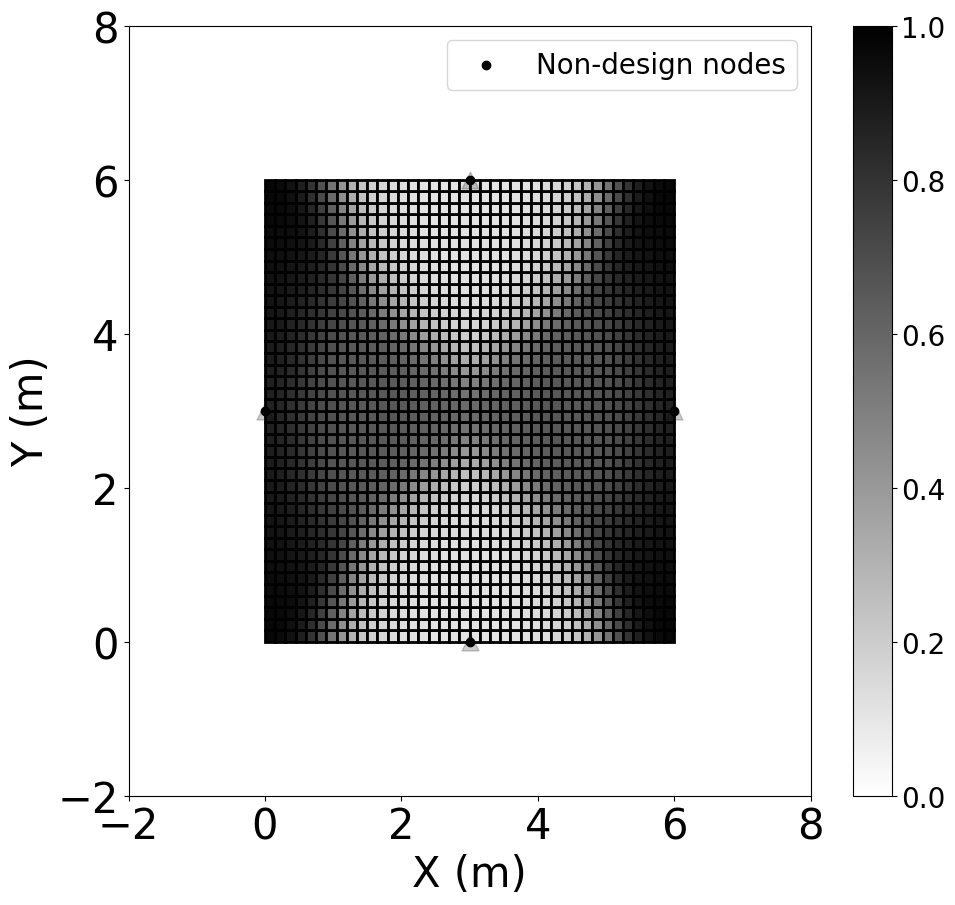

 41%|████▏     | 85/205 [04:47<06:29,  3.25s/it]

Iter85, alpha=4.35, p=7.1


 42%|████▏     | 86/205 [04:50<06:05,  3.07s/it]

Train epoch 87  ,loss:0.19510713504145671
Iter86, alpha=4.3999999999999995, p=7.16


 42%|████▏     | 87/205 [04:52<05:48,  2.95s/it]

Train epoch 88  ,loss:0.18548166438221506
Iter87, alpha=4.45, p=7.22


 43%|████▎     | 88/205 [04:55<05:34,  2.86s/it]

Train epoch 89  ,loss:0.17694550647205132
Iter88, alpha=4.5, p=7.279999999999999


 43%|████▎     | 89/205 [04:58<05:25,  2.80s/it]

Train epoch 90  ,loss:0.1698414206970479
Iter89, alpha=4.55, p=7.34
Train epoch 91  ,loss:0.16328857627505852
837.3050769236015


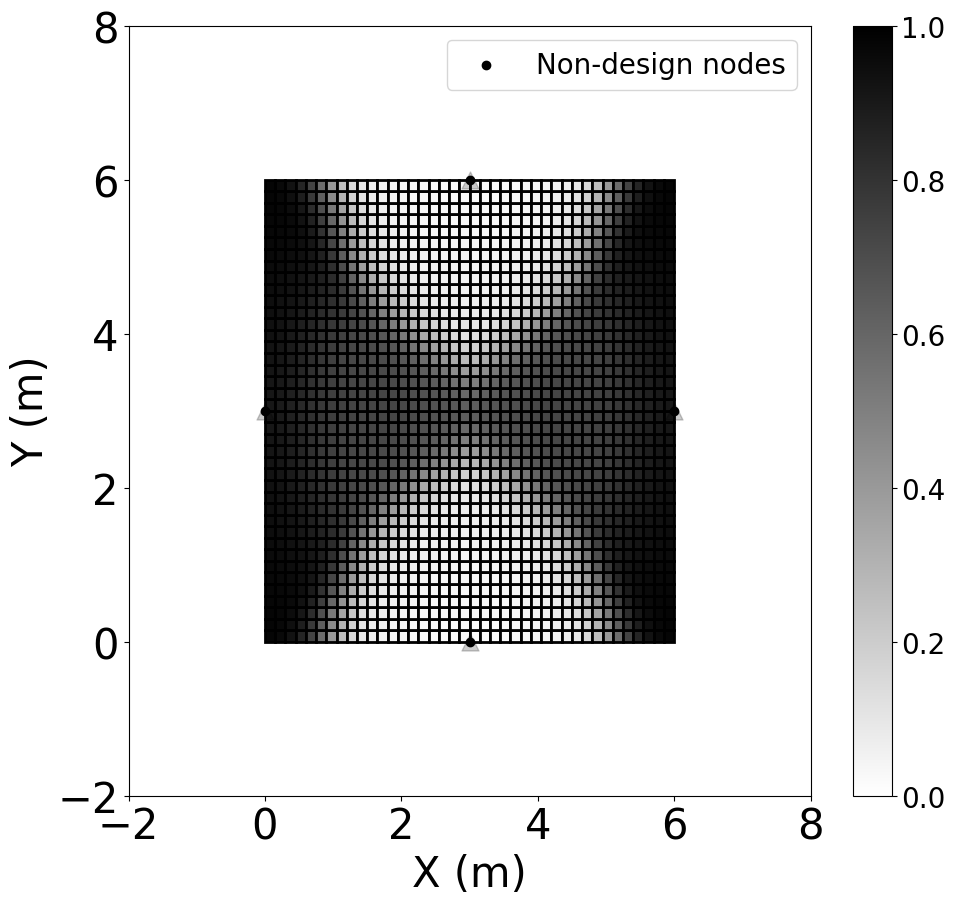

 44%|████▍     | 90/205 [05:01<06:03,  3.16s/it]

Iter90, alpha=4.6, p=7.3999999999999995


 44%|████▍     | 91/205 [05:04<05:43,  3.01s/it]

Train epoch 92  ,loss:0.15741927991337146
Iter91, alpha=4.6499999999999995, p=7.46


 45%|████▍     | 92/205 [05:07<05:28,  2.90s/it]

Train epoch 93  ,loss:0.15274698056523317
Iter92, alpha=4.7, p=7.52


 45%|████▌     | 93/205 [05:09<05:17,  2.83s/it]

Train epoch 94  ,loss:0.14884965179299944
Iter93, alpha=4.75, p=7.58


 46%|████▌     | 94/205 [05:12<05:08,  2.78s/it]

Train epoch 95  ,loss:0.1452024350230129
Iter94, alpha=4.8, p=7.64
Train epoch 96  ,loss:0.14204153809880624
828.1400374891361


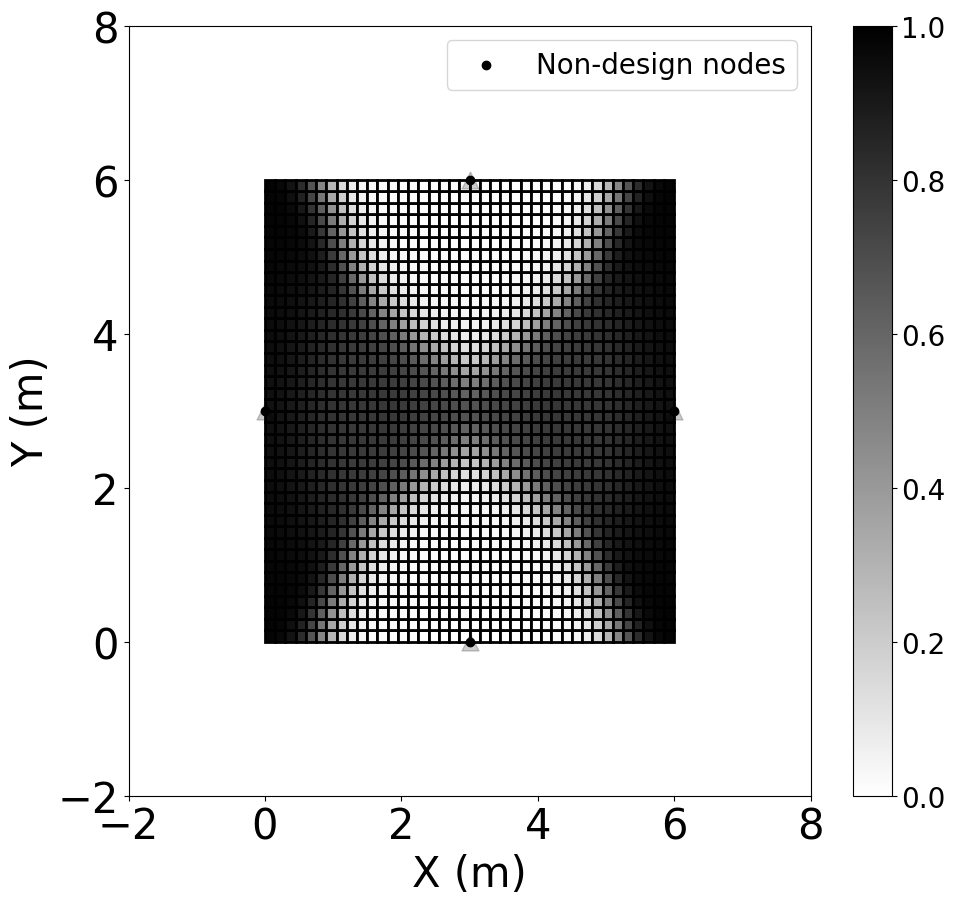

 46%|████▋     | 95/205 [05:16<05:45,  3.14s/it]

Iter95, alpha=4.85, p=7.7


 47%|████▋     | 96/205 [05:19<05:27,  3.00s/it]

Train epoch 97  ,loss:0.13944267318601306
Iter96, alpha=4.9, p=7.76


 47%|████▋     | 97/205 [05:22<05:15,  2.92s/it]

Train epoch 98  ,loss:0.13695483694514066
Iter97, alpha=4.95, p=7.819999999999999


 48%|████▊     | 98/205 [05:24<05:04,  2.85s/it]

Train epoch 99  ,loss:0.1345305266627882
Iter98, alpha=5.0, p=7.88


 48%|████▊     | 99/205 [05:27<04:56,  2.80s/it]

Train epoch 100  ,loss:0.13250120738505197
Iter99, alpha=5.05, p=7.9399999999999995
Train epoch 101  ,loss:0.1307926278966566
830.7519505724295


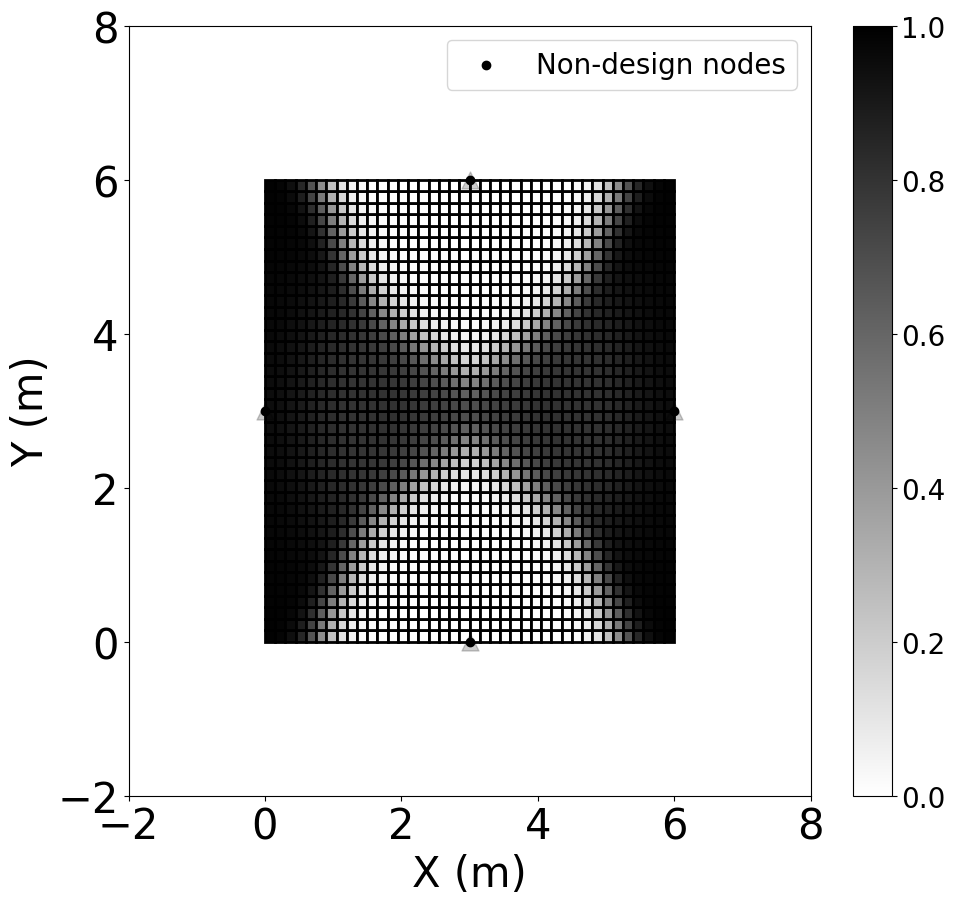

 49%|████▉     | 100/205 [05:31<05:40,  3.24s/it]

Iter100, alpha=5.1, p=8.0


 49%|████▉     | 101/205 [05:34<05:20,  3.08s/it]

Train epoch 102  ,loss:0.12918874168033703
Iter101, alpha=5.15, p=8.0


 50%|████▉     | 102/205 [05:37<05:06,  2.97s/it]

Train epoch 103  ,loss:0.1271553716446199
Iter102, alpha=5.2, p=8.0


 50%|█████     | 103/205 [05:39<04:55,  2.90s/it]

Train epoch 104  ,loss:0.12543257044960868
Iter103, alpha=5.25, p=8.0


 51%|█████     | 104/205 [05:42<04:46,  2.84s/it]

Train epoch 105  ,loss:0.1238177798591912
Iter104, alpha=5.3, p=8.0
Train epoch 106  ,loss:0.12224252608886889
826.864337772838


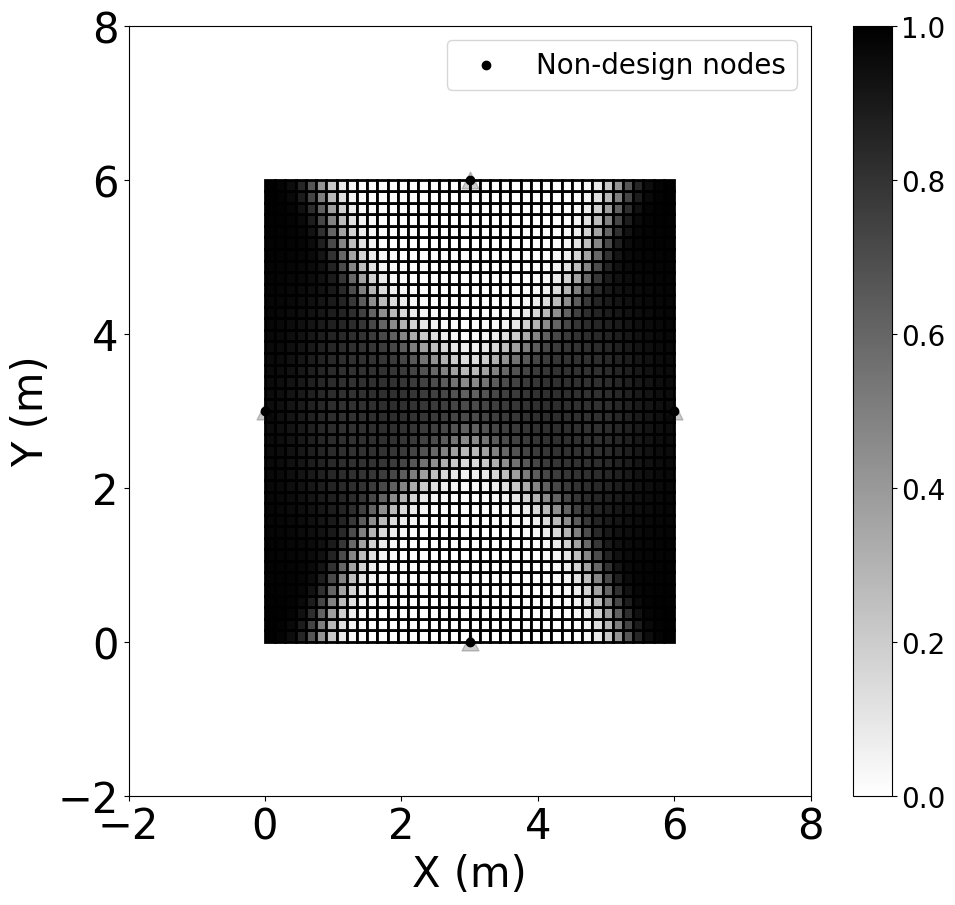

 51%|█████     | 105/205 [05:46<05:25,  3.25s/it]

Iter105, alpha=5.35, p=8.0


 52%|█████▏    | 106/205 [05:49<05:06,  3.09s/it]

Train epoch 107  ,loss:0.1208425659455473
Iter106, alpha=5.4, p=8.0


 52%|█████▏    | 107/205 [05:52<04:51,  2.97s/it]

Train epoch 108  ,loss:0.1195623215338598
Iter107, alpha=5.45, p=8.0


 53%|█████▎    | 108/205 [05:54<04:40,  2.89s/it]

Train epoch 109  ,loss:0.11828900307378917
Iter108, alpha=5.5, p=8.0


 53%|█████▎    | 109/205 [05:57<04:31,  2.83s/it]

Train epoch 110  ,loss:0.11711162722369449
Iter109, alpha=5.55, p=8.0
Train epoch 111  ,loss:0.11607387802652064
820.245516170096


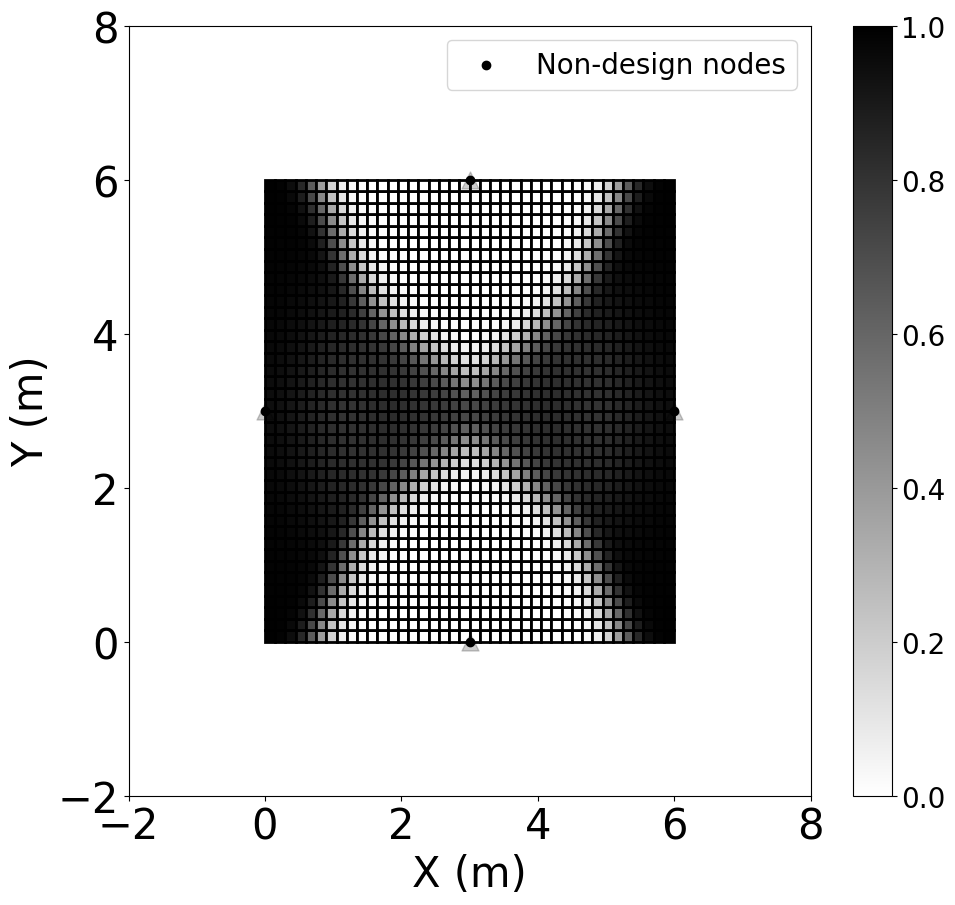

 54%|█████▎    | 110/205 [06:01<05:02,  3.18s/it]

Iter110, alpha=5.6, p=8.0


 54%|█████▍    | 111/205 [06:04<04:45,  3.03s/it]

Train epoch 112  ,loss:0.11507354006556039
Iter111, alpha=5.65, p=8.0


 55%|█████▍    | 112/205 [06:06<04:32,  2.93s/it]

Train epoch 113  ,loss:0.1141279646837241
Iter112, alpha=5.7, p=8.0


 55%|█████▌    | 113/205 [06:09<04:23,  2.86s/it]

Train epoch 114  ,loss:0.11328343602098002
Iter113, alpha=5.75, p=8.0


 56%|█████▌    | 114/205 [06:12<04:15,  2.81s/it]

Train epoch 115  ,loss:0.11247426532390656
Iter114, alpha=5.8, p=8.0
Train epoch 116  ,loss:0.11167172318999229
818.1329331756706


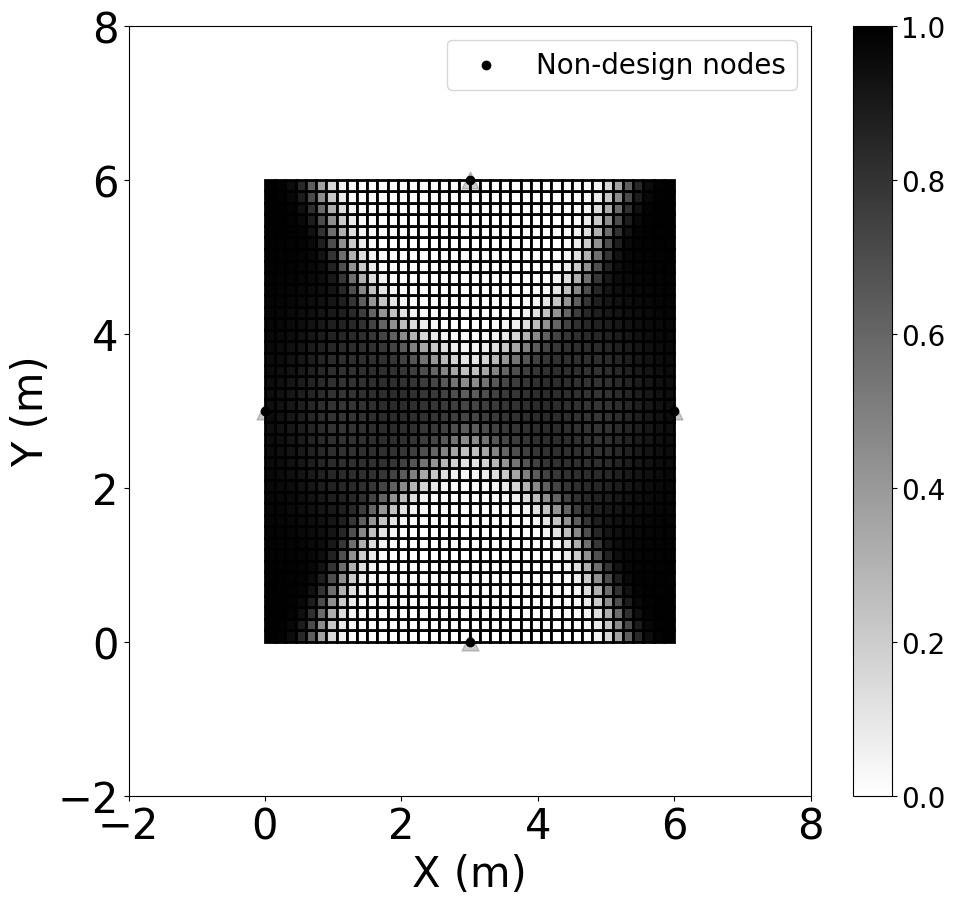

 56%|█████▌    | 115/205 [06:16<04:52,  3.25s/it]

Iter115, alpha=5.85, p=8.0


 57%|█████▋    | 116/205 [06:19<04:34,  3.08s/it]

Train epoch 117  ,loss:0.11092893942781441
Iter116, alpha=5.9, p=8.0


 57%|█████▋    | 117/205 [06:21<04:20,  2.96s/it]

Train epoch 118  ,loss:0.11023758104402705
Iter117, alpha=5.95, p=8.0


 58%|█████▊    | 118/205 [06:24<04:10,  2.88s/it]

Train epoch 119  ,loss:0.10955451679513513
Iter118, alpha=6.0, p=8.0


 58%|█████▊    | 119/205 [06:27<04:02,  2.82s/it]

Train epoch 120  ,loss:0.10890843218341699
Iter119, alpha=6.05, p=8.0
Train epoch 121  ,loss:0.10830870738407913
817.9001829556022


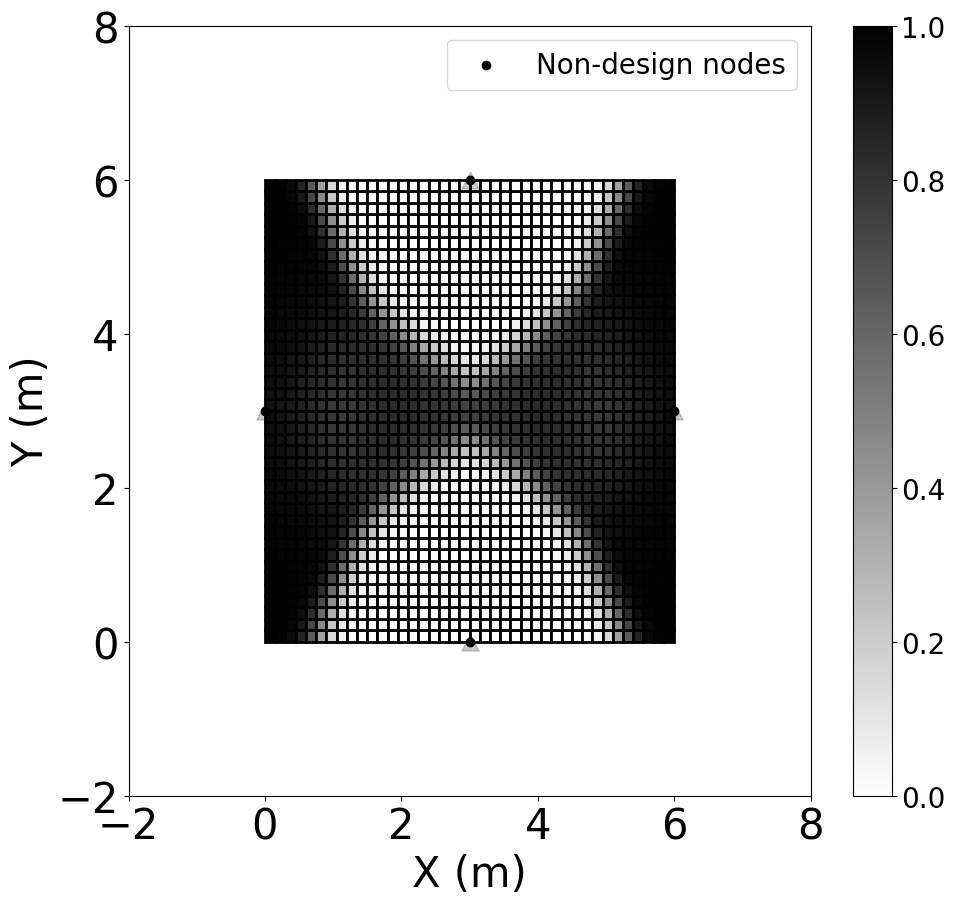

 59%|█████▊    | 120/205 [06:31<04:29,  3.18s/it]

Iter120, alpha=6.1, p=8.0


 59%|█████▉    | 121/205 [06:34<04:14,  3.03s/it]

Train epoch 122  ,loss:0.10772002092205098
Iter121, alpha=6.15, p=8.0


 60%|█████▉    | 122/205 [06:36<04:02,  2.93s/it]

Train epoch 123  ,loss:0.10715780138915712
Iter122, alpha=6.2, p=8.0


 60%|██████    | 123/205 [06:39<03:54,  2.86s/it]

Train epoch 124  ,loss:0.10663799111452646
Iter123, alpha=6.25, p=8.0


 60%|██████    | 124/205 [06:42<03:47,  2.81s/it]

Train epoch 125  ,loss:0.10612416396688336
Iter124, alpha=6.3, p=8.0
Train epoch 126  ,loss:0.1056178907367903
816.2217094935754


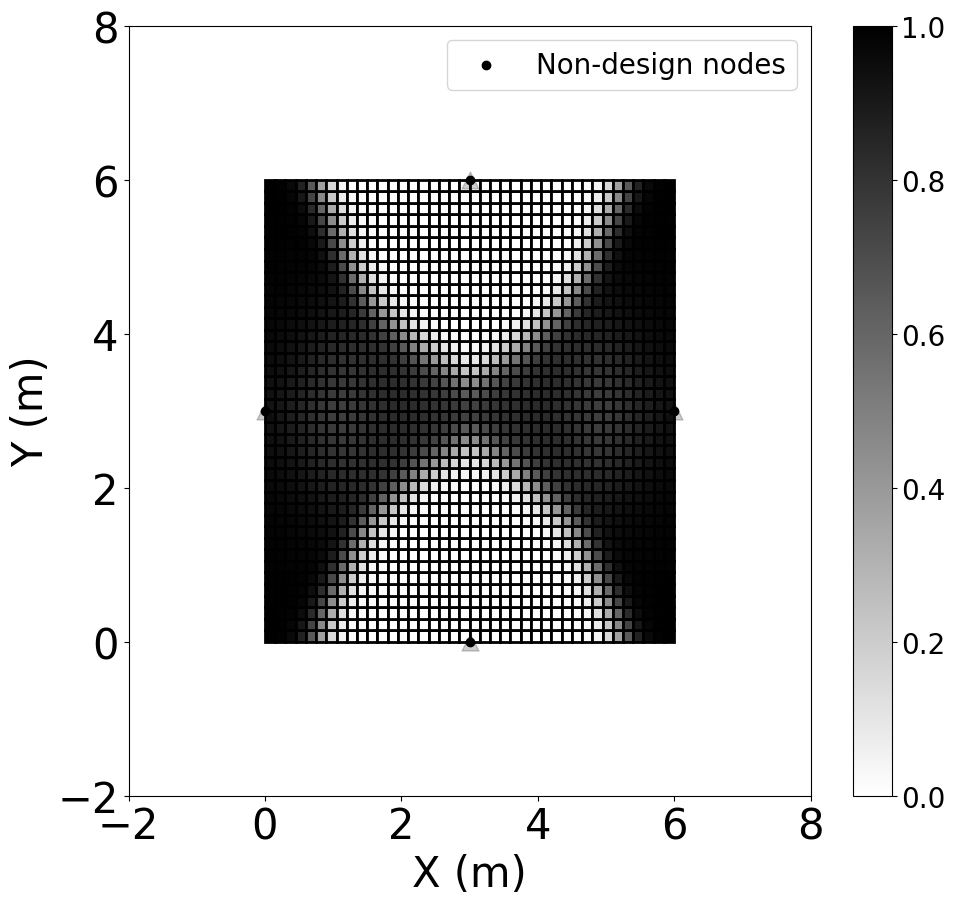

 61%|██████    | 125/205 [06:46<04:20,  3.26s/it]

Iter125, alpha=6.35, p=8.0


 61%|██████▏   | 126/205 [06:49<04:03,  3.09s/it]

Train epoch 127  ,loss:0.1051454514279368
Iter126, alpha=6.4, p=8.0


 62%|██████▏   | 127/205 [06:51<03:51,  2.97s/it]

Train epoch 128  ,loss:0.10468493575318333
Iter127, alpha=6.45, p=8.0


 62%|██████▏   | 128/205 [06:54<03:41,  2.88s/it]

Train epoch 129  ,loss:0.10422995300608245
Iter128, alpha=6.5, p=8.0


 63%|██████▎   | 129/205 [06:57<03:34,  2.82s/it]

Train epoch 130  ,loss:0.103803642862695
Iter129, alpha=6.55, p=8.0
Train epoch 131  ,loss:0.1033906607735114
814.08671494432


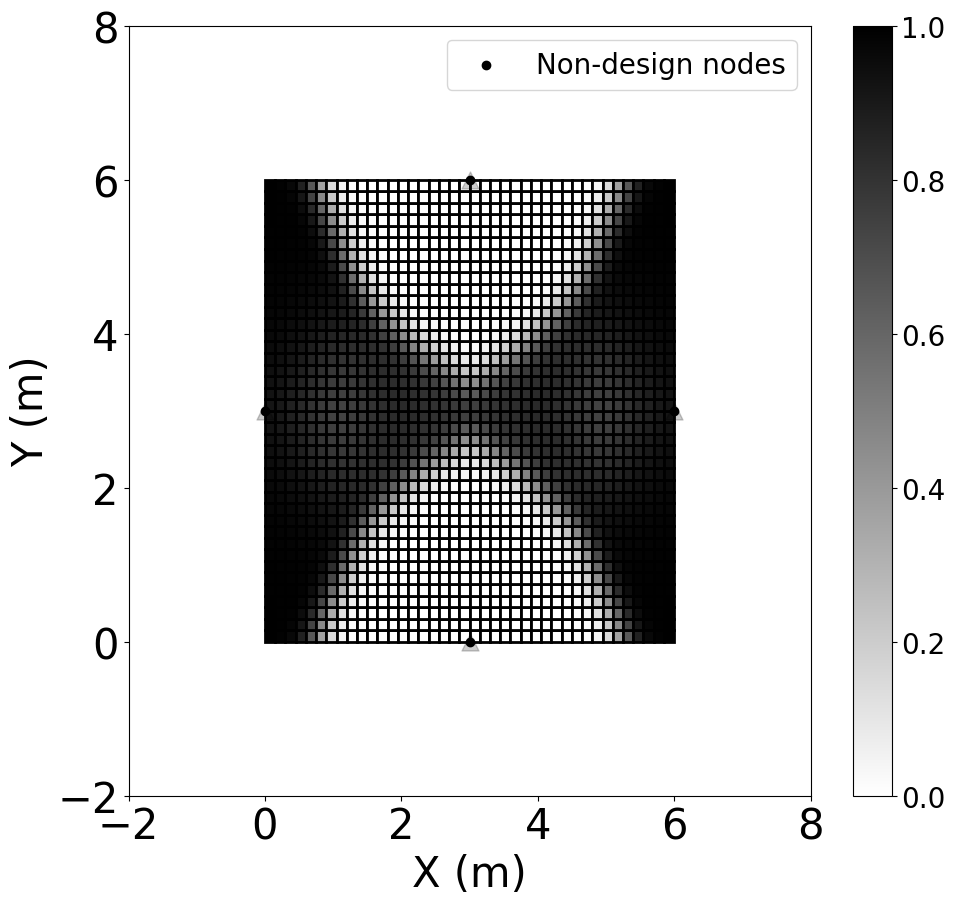

 63%|██████▎   | 130/205 [07:01<03:58,  3.17s/it]

Iter130, alpha=6.6, p=8.0


 64%|██████▍   | 131/205 [07:03<03:44,  3.03s/it]

Train epoch 132  ,loss:0.10298423570206543
Iter131, alpha=6.65, p=8.0


 64%|██████▍   | 132/205 [07:06<03:33,  2.92s/it]

Train epoch 133  ,loss:0.10259541588252957
Iter132, alpha=6.7, p=8.0


 65%|██████▍   | 133/205 [07:09<03:25,  2.86s/it]

Train epoch 134  ,loss:0.10221756434793491
Iter133, alpha=6.75, p=8.0


 65%|██████▌   | 134/205 [07:11<03:19,  2.81s/it]

Train epoch 135  ,loss:0.10184608835450598
Iter134, alpha=6.8, p=8.0
Train epoch 136  ,loss:0.10148880473783045
812.8820329106709


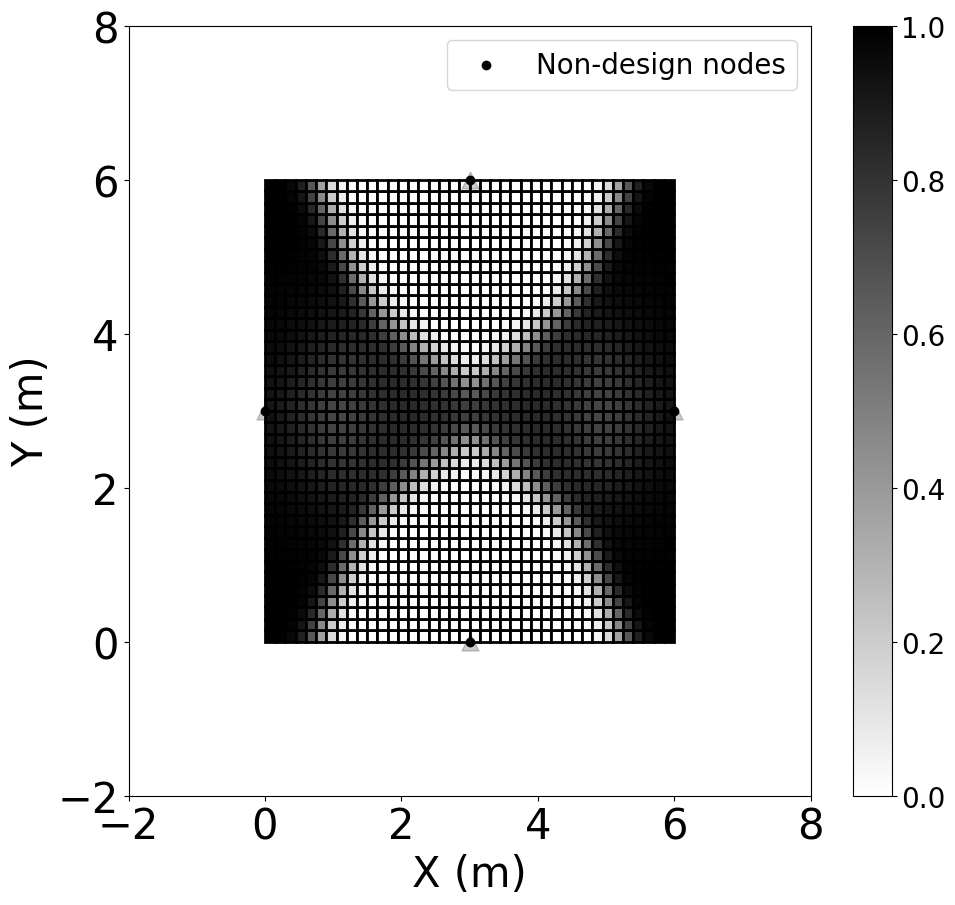

 66%|██████▌   | 135/205 [07:15<03:41,  3.16s/it]

Iter135, alpha=6.85, p=8.0


 66%|██████▋   | 136/205 [07:18<03:28,  3.02s/it]

Train epoch 137  ,loss:0.10114136335513081
Iter136, alpha=6.9, p=8.0


 67%|██████▋   | 137/205 [07:21<03:18,  2.92s/it]

Train epoch 138  ,loss:0.10080074097379575
Iter137, alpha=6.95, p=8.0


 67%|██████▋   | 138/205 [07:23<03:10,  2.85s/it]

Train epoch 139  ,loss:0.10047220479727469
Iter138, alpha=7.0, p=8.0


 68%|██████▊   | 139/205 [07:26<03:06,  2.82s/it]

Train epoch 140  ,loss:0.10014882825855258
Iter139, alpha=7.05, p=8.0
Train epoch 141  ,loss:0.09982926319251724
812.2885263187555


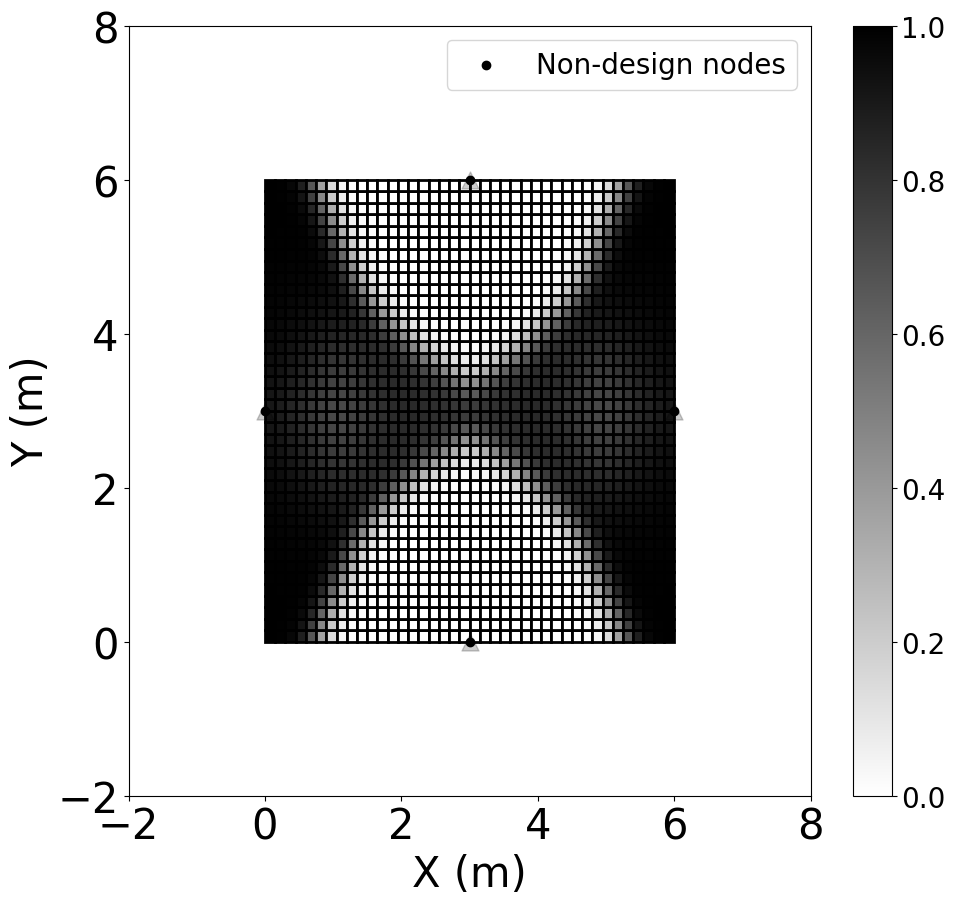

 68%|██████▊   | 140/205 [07:31<03:34,  3.29s/it]

Iter140, alpha=7.1, p=8.0


 69%|██████▉   | 141/205 [07:33<03:19,  3.11s/it]

Train epoch 142  ,loss:0.09952210227701153
Iter141, alpha=7.15, p=8.0


 69%|██████▉   | 142/205 [07:36<03:08,  3.00s/it]

Train epoch 143  ,loss:0.09921944520444388
Iter142, alpha=7.2, p=8.0


 70%|██████▉   | 143/205 [07:39<03:00,  2.91s/it]

Train epoch 144  ,loss:0.09892248446213214
Iter143, alpha=7.25, p=8.0


 70%|███████   | 144/205 [07:41<02:53,  2.84s/it]

Train epoch 145  ,loss:0.09863415353060606
Iter144, alpha=7.3, p=8.0
Train epoch 146  ,loss:0.0983471245467263
811.8698944003113


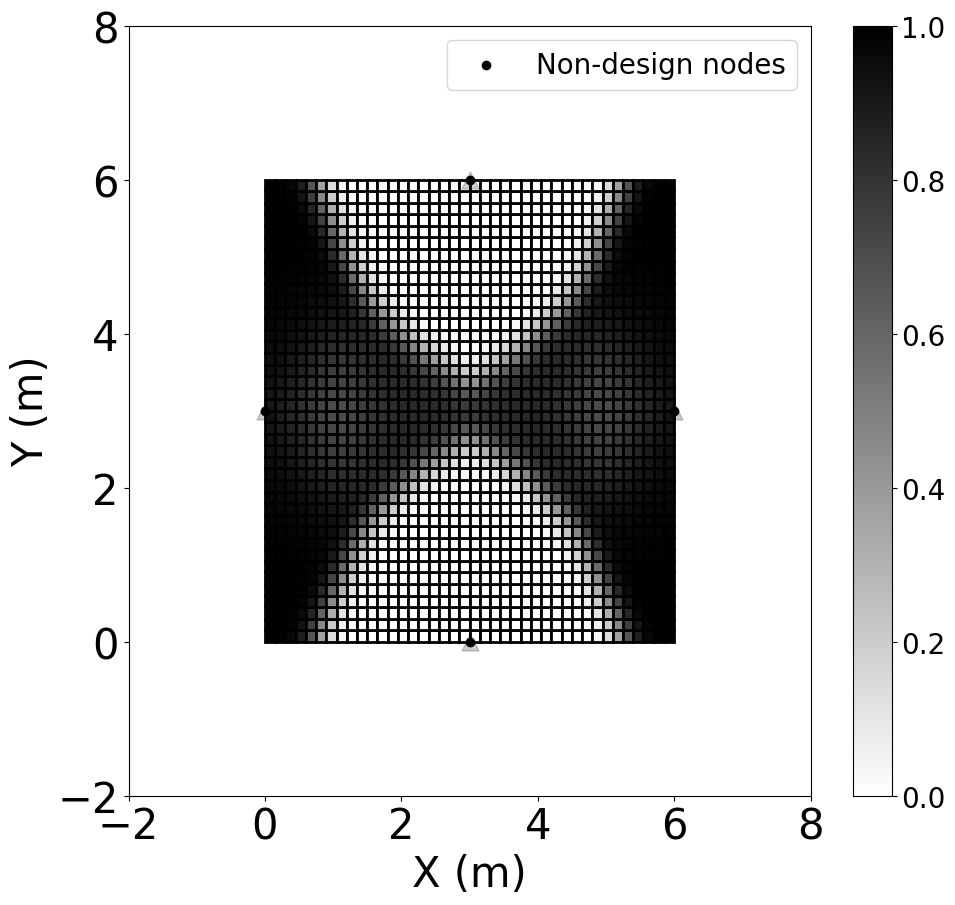

 71%|███████   | 145/205 [07:46<03:15,  3.26s/it]

Iter145, alpha=7.35, p=8.0


 71%|███████   | 146/205 [07:48<03:02,  3.09s/it]

Train epoch 147  ,loss:0.09807037006153933
Iter146, alpha=7.4, p=8.0


 72%|███████▏  | 147/205 [07:51<02:52,  2.97s/it]

Train epoch 148  ,loss:0.09780067498516044
Iter147, alpha=7.45, p=8.0


 72%|███████▏  | 148/205 [07:54<02:44,  2.88s/it]

Train epoch 149  ,loss:0.0975304293369913
Iter148, alpha=7.5, p=8.0


 73%|███████▎  | 149/205 [07:56<02:37,  2.82s/it]

Train epoch 150  ,loss:0.0972612263293995
Iter149, alpha=7.55, p=8.0
Train epoch 151  ,loss:0.0969922776744029
811.2476178715997


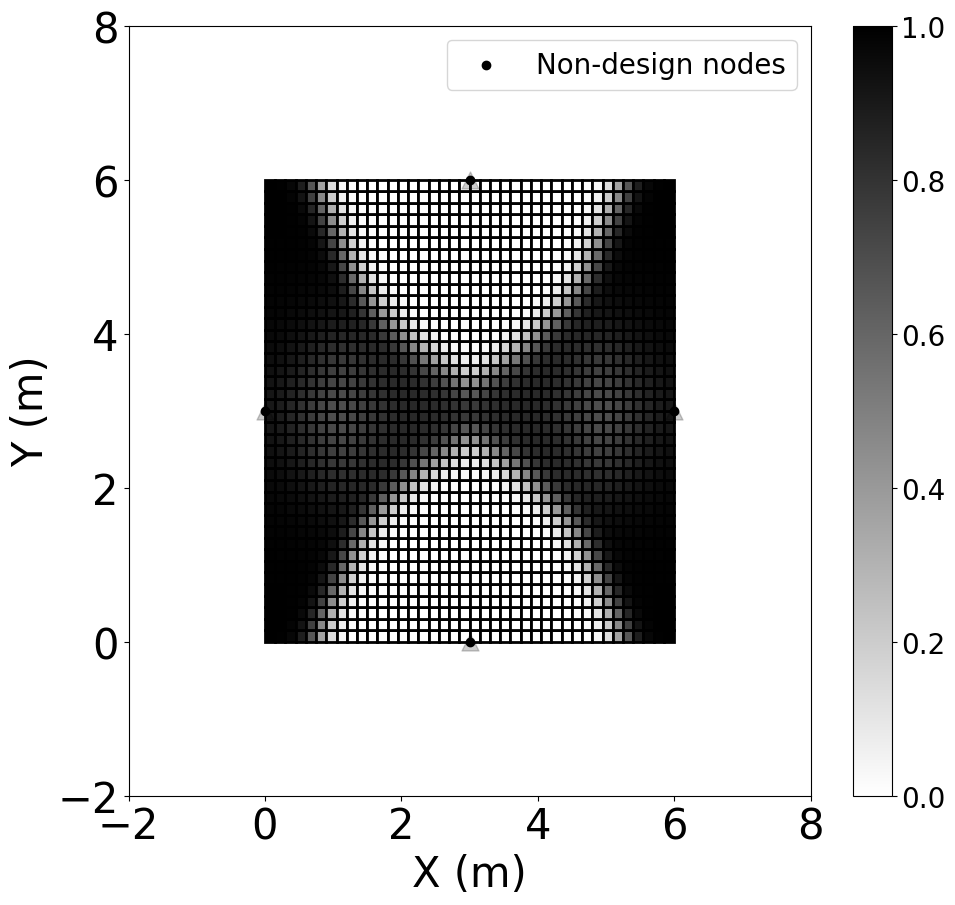

 73%|███████▎  | 150/205 [08:00<02:54,  3.17s/it]

Iter150, alpha=7.6, p=8.0


 74%|███████▎  | 151/205 [08:03<02:43,  3.02s/it]

Train epoch 152  ,loss:0.0967216256160254
Iter151, alpha=7.65, p=8.0


 74%|███████▍  | 152/205 [08:06<02:34,  2.92s/it]

Train epoch 153  ,loss:0.096453653414917
Iter152, alpha=7.7, p=8.0


 75%|███████▍  | 153/205 [08:08<02:28,  2.85s/it]

Train epoch 154  ,loss:0.09618205223407184
Iter153, alpha=7.75, p=8.0


 75%|███████▌  | 154/205 [08:11<02:22,  2.80s/it]

Train epoch 155  ,loss:0.09591045955664446
Iter154, alpha=7.8, p=8.0
Train epoch 156  ,loss:0.09564066541290596
810.8133547051267


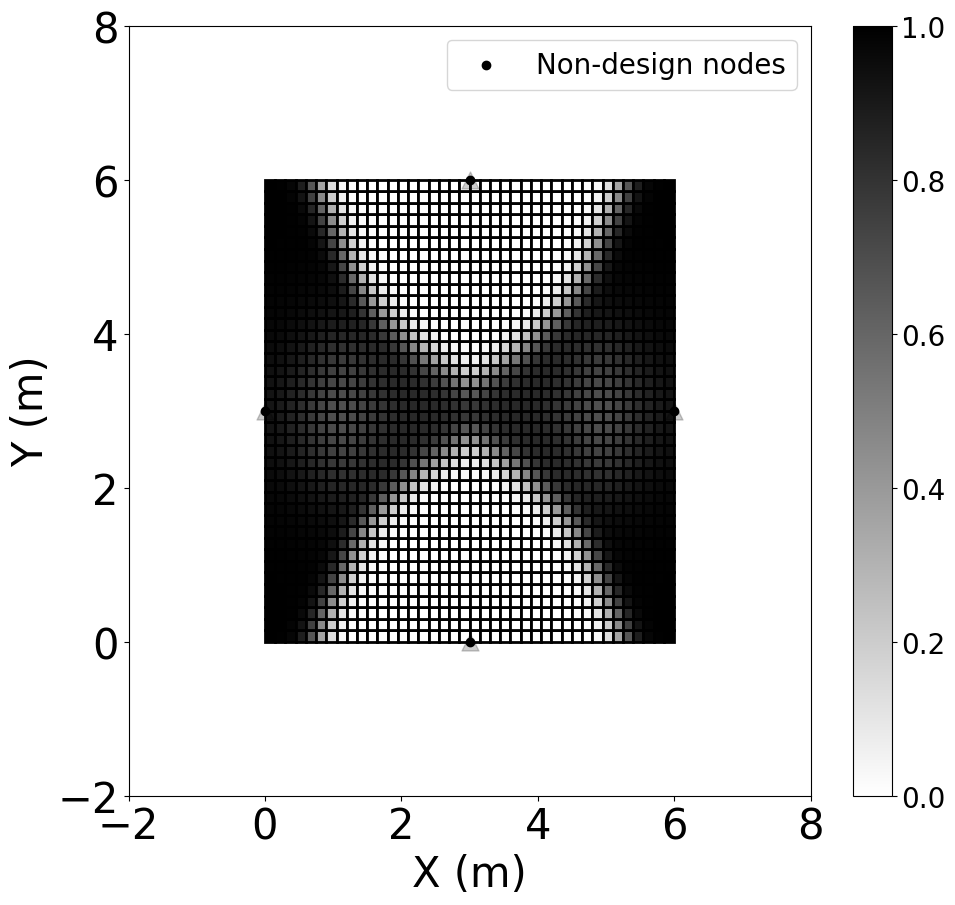

 76%|███████▌  | 155/205 [08:15<02:41,  3.23s/it]

Iter155, alpha=7.85, p=8.0


 76%|███████▌  | 156/205 [08:18<02:29,  3.06s/it]

Train epoch 157  ,loss:0.09537183639340091
Iter156, alpha=7.9, p=8.0


 77%|███████▋  | 157/205 [08:21<02:21,  2.94s/it]

Train epoch 158  ,loss:0.09511184869781658
Iter157, alpha=7.95, p=8.0


 77%|███████▋  | 158/205 [08:23<02:14,  2.85s/it]

Train epoch 159  ,loss:0.09486138443974028
Iter158, alpha=8.0, p=8.0


 78%|███████▊  | 159/205 [08:26<02:08,  2.80s/it]

Train epoch 160  ,loss:0.09461944368028573
Iter159, alpha=8.05, p=8.0
Train epoch 161  ,loss:0.0943871175580878
810.0946473231636


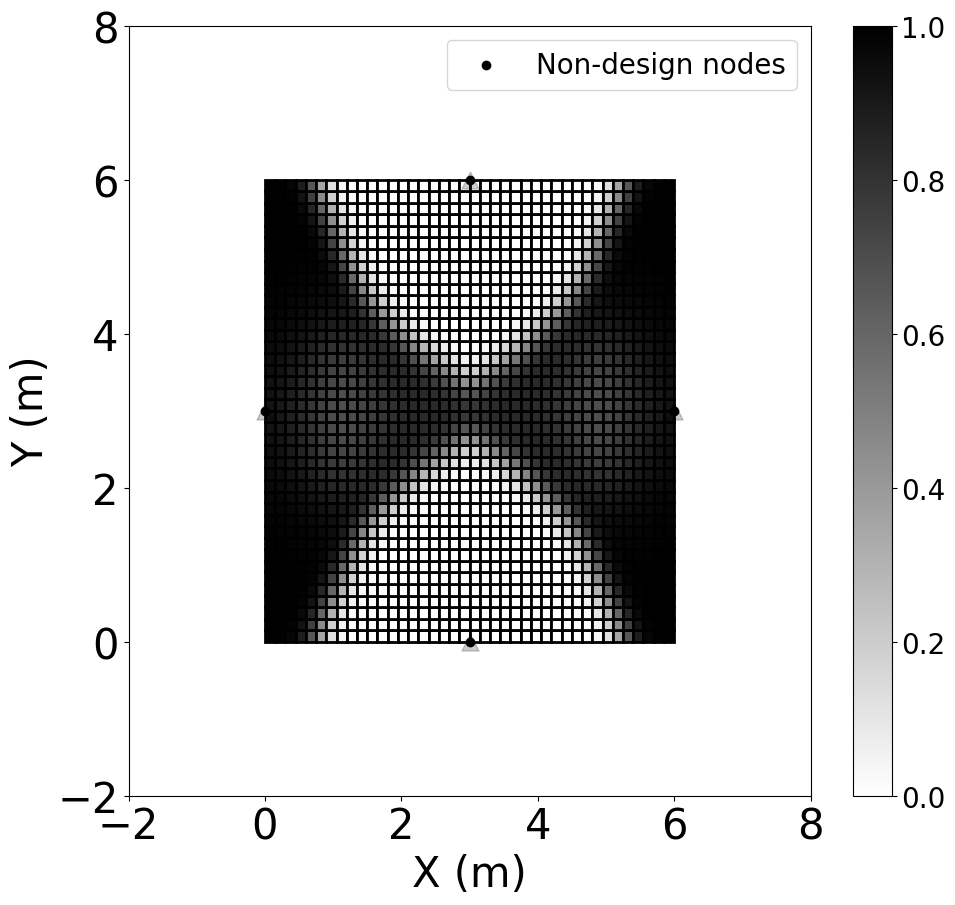

 78%|███████▊  | 160/205 [08:30<02:21,  3.15s/it]

Iter160, alpha=8.1, p=8.0


 79%|███████▊  | 161/205 [08:33<02:12,  3.00s/it]

Train epoch 162  ,loss:0.09416340258954538
Iter161, alpha=8.15, p=8.0


 79%|███████▉  | 162/205 [08:35<02:04,  2.90s/it]

Train epoch 163  ,loss:0.0939461617882473
Iter162, alpha=8.2, p=8.0


 80%|███████▉  | 163/205 [08:38<01:58,  2.83s/it]

Train epoch 164  ,loss:0.0937320116694388
Iter163, alpha=8.25, p=8.0


 80%|████████  | 164/205 [08:41<01:53,  2.78s/it]

Train epoch 165  ,loss:0.09351971272968895
Iter164, alpha=8.3, p=8.0
Train epoch 166  ,loss:0.09330384591141343
809.4025019653732


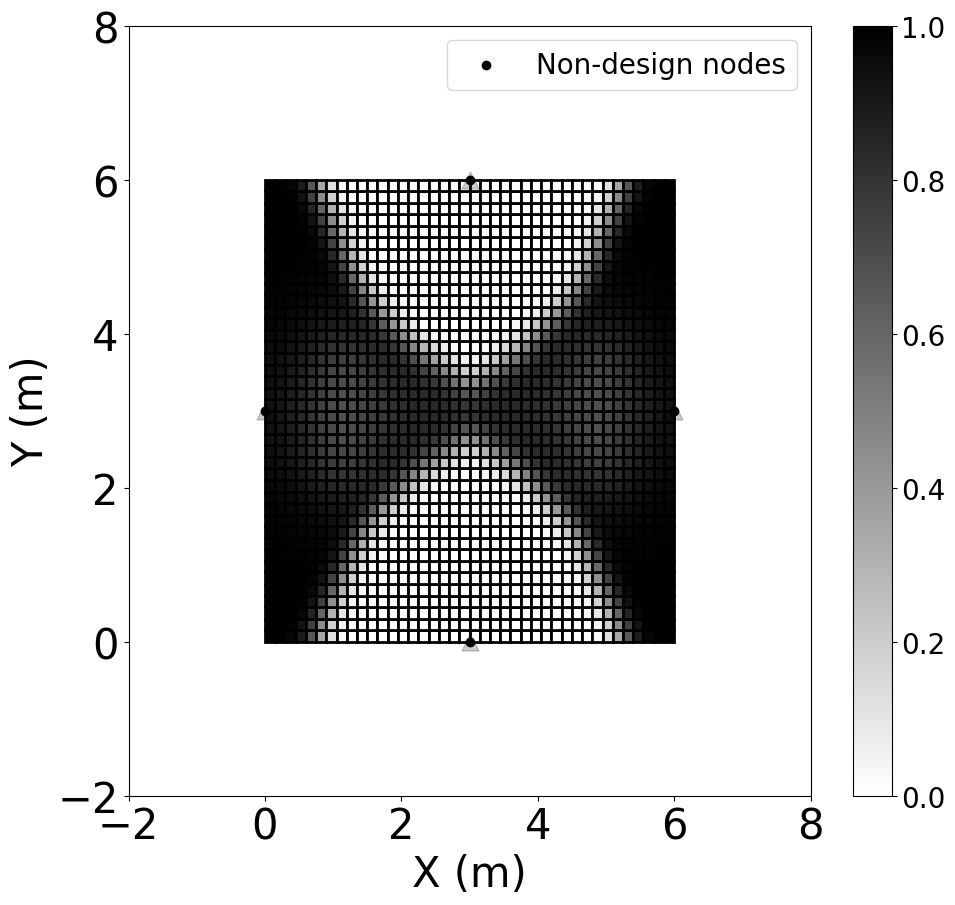

 80%|████████  | 165/205 [08:45<02:09,  3.23s/it]

Iter165, alpha=8.35, p=8.0


 81%|████████  | 166/205 [08:48<02:00,  3.10s/it]

Train epoch 167  ,loss:0.09308507658010488
Iter166, alpha=8.4, p=8.0


 81%|████████▏ | 167/205 [08:50<01:52,  2.97s/it]

Train epoch 168  ,loss:0.09286395698556249
Iter167, alpha=8.45, p=8.0


 82%|████████▏ | 168/205 [08:53<01:46,  2.87s/it]

Train epoch 169  ,loss:0.09264444028889954
Iter168, alpha=8.5, p=8.0


 82%|████████▏ | 169/205 [08:56<01:41,  2.81s/it]

Train epoch 170  ,loss:0.09243124817698492
Iter169, alpha=8.55, p=8.0
Train epoch 171  ,loss:0.09222227213569087
808.9959919273886


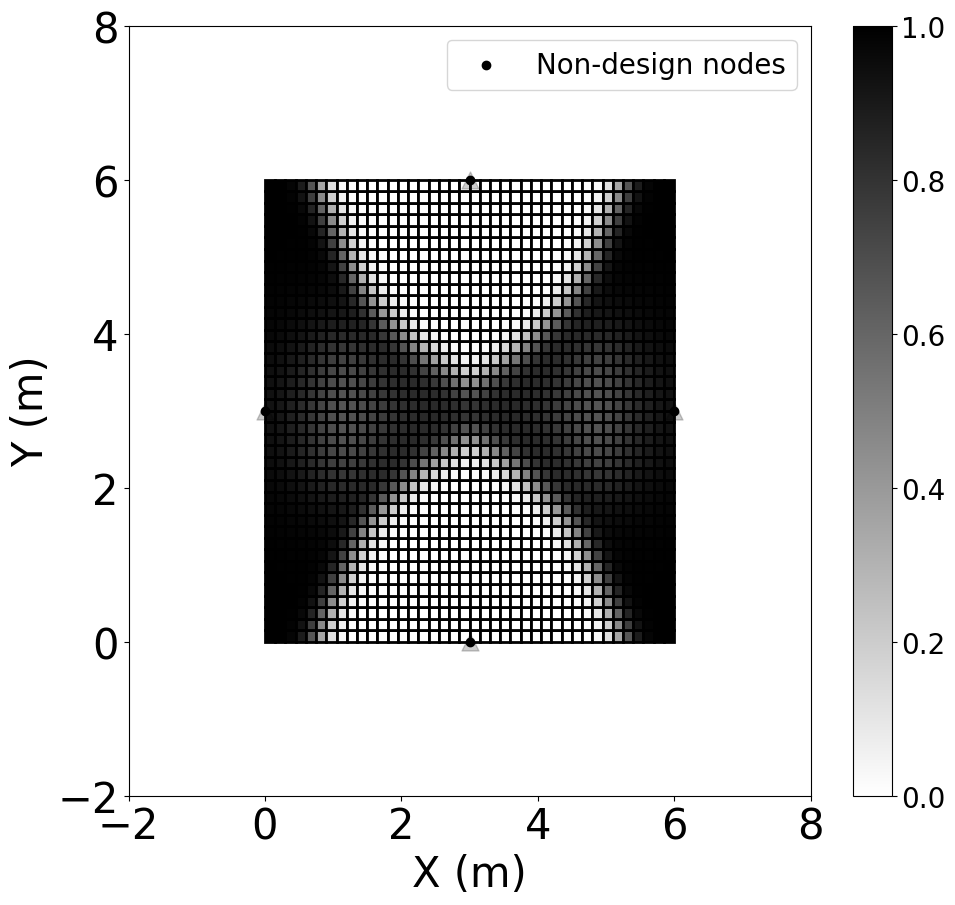

 83%|████████▎ | 170/205 [09:00<01:50,  3.16s/it]

Iter170, alpha=8.6, p=8.0


 83%|████████▎ | 171/205 [09:02<01:42,  3.01s/it]

Train epoch 172  ,loss:0.09201765370278604
Iter171, alpha=8.65, p=8.0


 84%|████████▍ | 172/205 [09:05<01:35,  2.91s/it]

Train epoch 173  ,loss:0.09181711394906333
Iter172, alpha=8.7, p=8.0


 84%|████████▍ | 173/205 [09:08<01:30,  2.84s/it]

Train epoch 174  ,loss:0.09161687743888759
Iter173, alpha=8.75, p=8.0


 85%|████████▍ | 174/205 [09:10<01:26,  2.79s/it]

Train epoch 175  ,loss:0.09141725880729357
Iter174, alpha=8.8, p=8.0
Train epoch 176  ,loss:0.09121788676949617
808.4448087353104


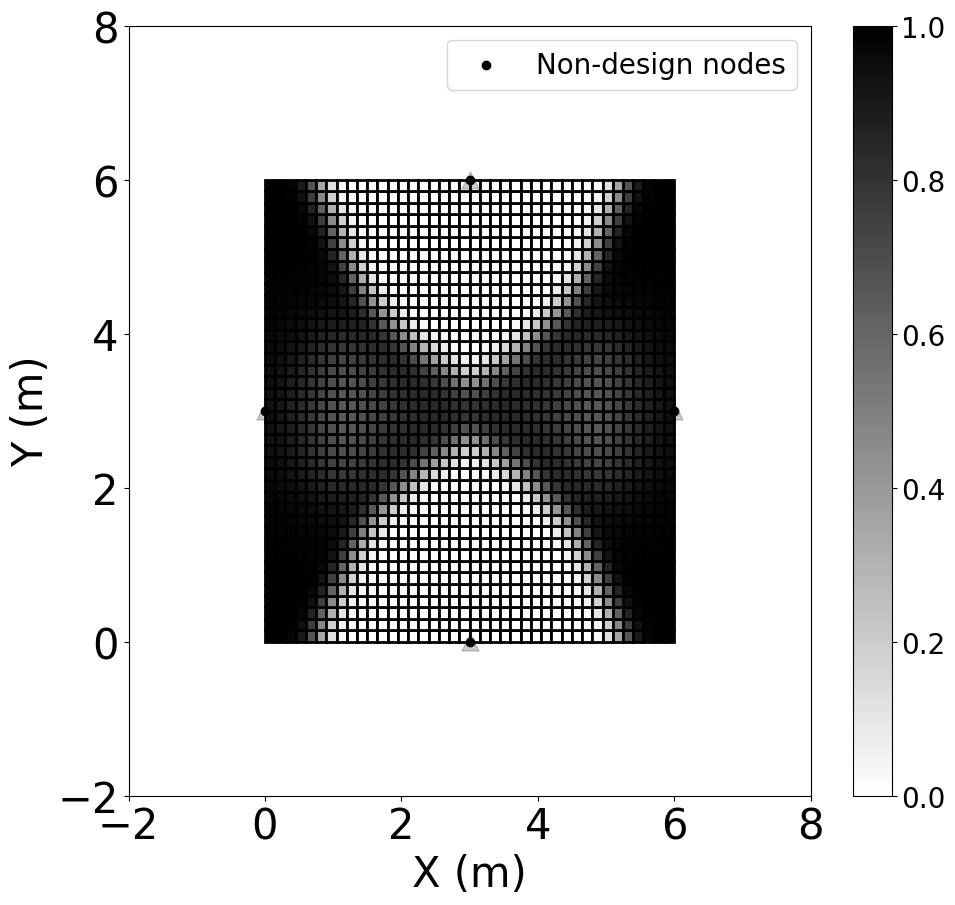

 85%|████████▌ | 175/205 [09:14<01:34,  3.15s/it]

Iter175, alpha=8.85, p=8.0


 86%|████████▌ | 176/205 [09:17<01:27,  3.00s/it]

Train epoch 177  ,loss:0.09101975197817946
Iter176, alpha=8.9, p=8.0


 86%|████████▋ | 177/205 [09:20<01:21,  2.90s/it]

Train epoch 178  ,loss:0.09082150064253675
Iter177, alpha=8.95, p=8.0


 87%|████████▋ | 178/205 [09:22<01:16,  2.85s/it]

Train epoch 179  ,loss:0.09062558040436974
Iter178, alpha=9.0, p=8.0


 87%|████████▋ | 179/205 [09:25<01:12,  2.79s/it]

Train epoch 180  ,loss:0.09043228747523101
Iter179, alpha=9.05, p=8.0
Train epoch 181  ,loss:0.0902436604538415
807.9310688709749


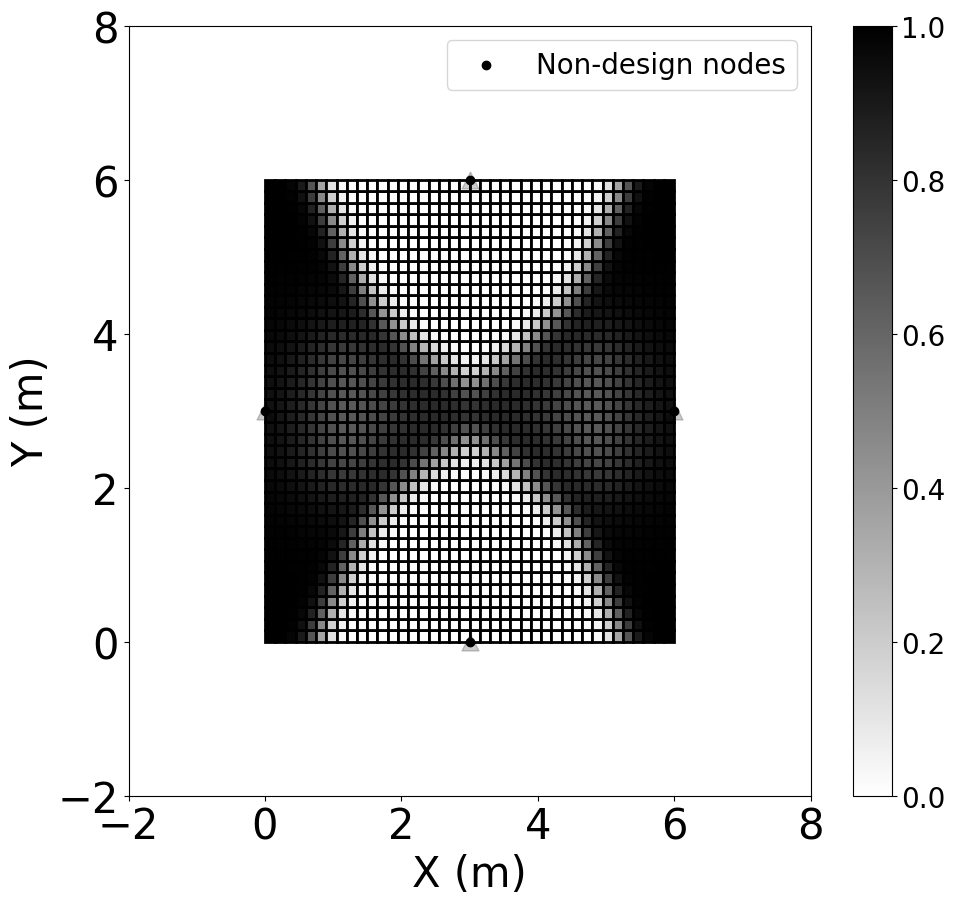

 88%|████████▊ | 180/205 [09:29<01:20,  3.23s/it]

Iter180, alpha=9.1, p=8.0


 88%|████████▊ | 181/205 [09:32<01:13,  3.06s/it]

Train epoch 182  ,loss:0.09005619275336457
Iter181, alpha=9.15, p=8.0


 89%|████████▉ | 182/205 [09:35<01:07,  2.94s/it]

Train epoch 183  ,loss:0.08986791763494115
Iter182, alpha=9.2, p=8.0


 89%|████████▉ | 183/205 [09:37<01:02,  2.86s/it]

Train epoch 184  ,loss:0.08968012436755447
Iter183, alpha=9.25, p=8.0


 90%|████████▉ | 184/205 [09:40<00:58,  2.80s/it]

Train epoch 185  ,loss:0.08949440433756546
Iter184, alpha=9.3, p=8.0
Train epoch 186  ,loss:0.08930950389654899
807.6837675333489


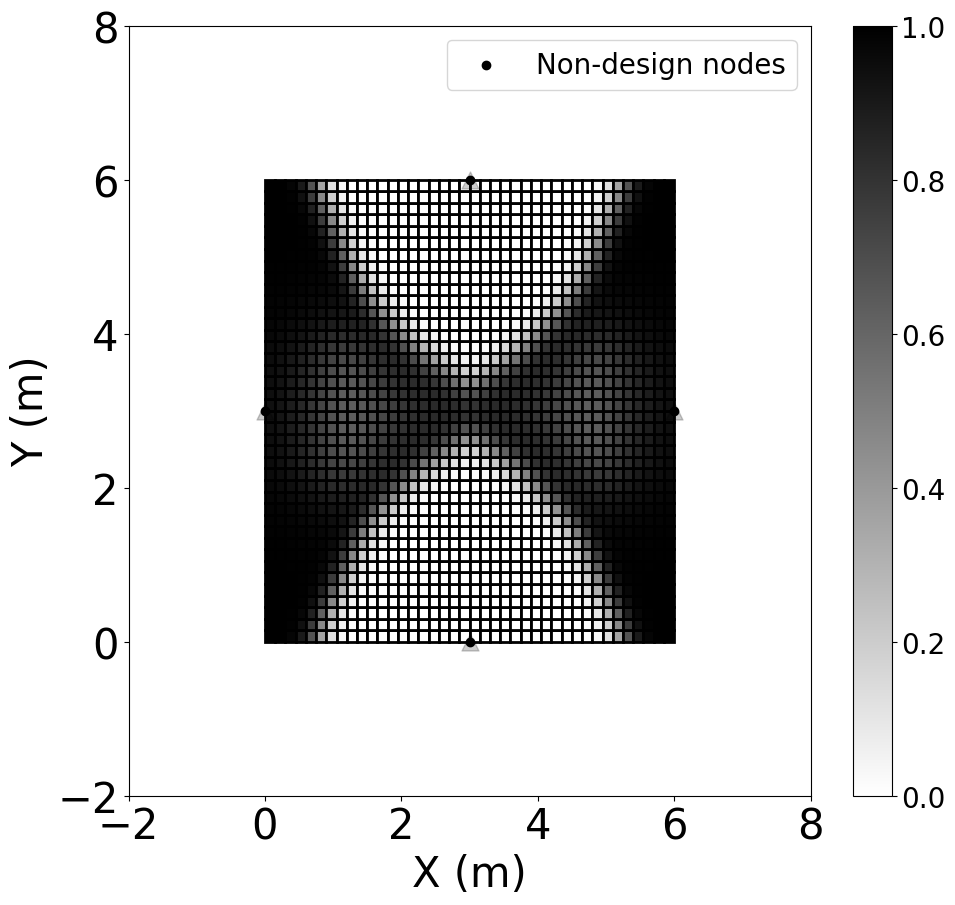

 90%|█████████ | 185/205 [09:44<01:04,  3.23s/it]

Iter185, alpha=9.35, p=8.0


 91%|█████████ | 186/205 [09:47<00:58,  3.06s/it]

Train epoch 187  ,loss:0.0891272313002569
Iter186, alpha=9.4, p=8.0


 91%|█████████ | 187/205 [09:49<00:52,  2.94s/it]

Train epoch 188  ,loss:0.08894618652897653
Iter187, alpha=9.45, p=8.0


 92%|█████████▏| 188/205 [09:52<00:48,  2.86s/it]

Train epoch 189  ,loss:0.08876559592421927
Iter188, alpha=9.5, p=8.0


 92%|█████████▏| 189/205 [09:55<00:44,  2.80s/it]

Train epoch 190  ,loss:0.08858589912077593
Iter189, alpha=9.55, p=8.0
Train epoch 191  ,loss:0.08840765754892517
807.3211136780478


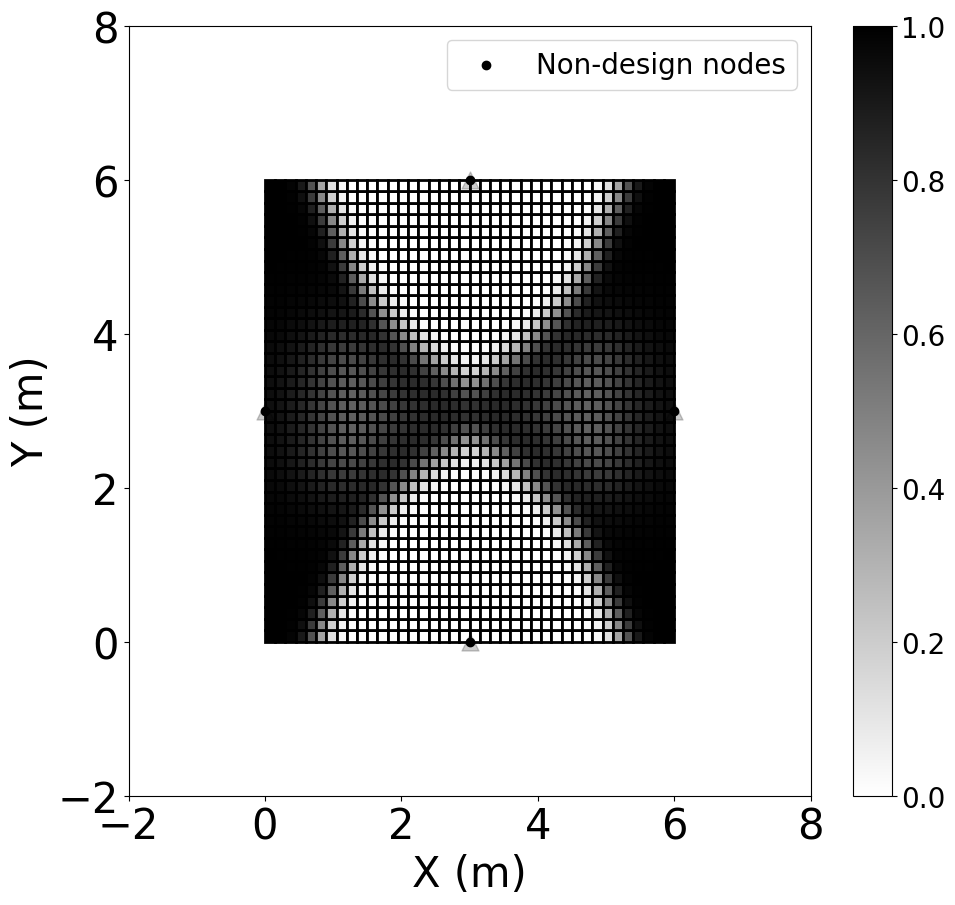

 93%|█████████▎| 190/205 [09:59<00:47,  3.15s/it]

Iter190, alpha=9.6, p=8.0


 93%|█████████▎| 191/205 [10:01<00:42,  3.01s/it]

Train epoch 192  ,loss:0.08822898315621495
Iter191, alpha=9.65, p=8.0


 94%|█████████▎| 192/205 [10:04<00:37,  2.90s/it]

Train epoch 193  ,loss:0.08805055176132107
Iter192, alpha=9.700000000000001, p=8.0


 94%|█████████▍| 193/205 [10:07<00:33,  2.83s/it]

Train epoch 194  ,loss:0.08787505459486619
Iter193, alpha=9.75, p=8.0


 95%|█████████▍| 194/205 [10:09<00:30,  2.79s/it]

Train epoch 195  ,loss:0.08770025244501571
Iter194, alpha=9.8, p=8.0
Train epoch 196  ,loss:0.08752703548433768
806.9634671565486


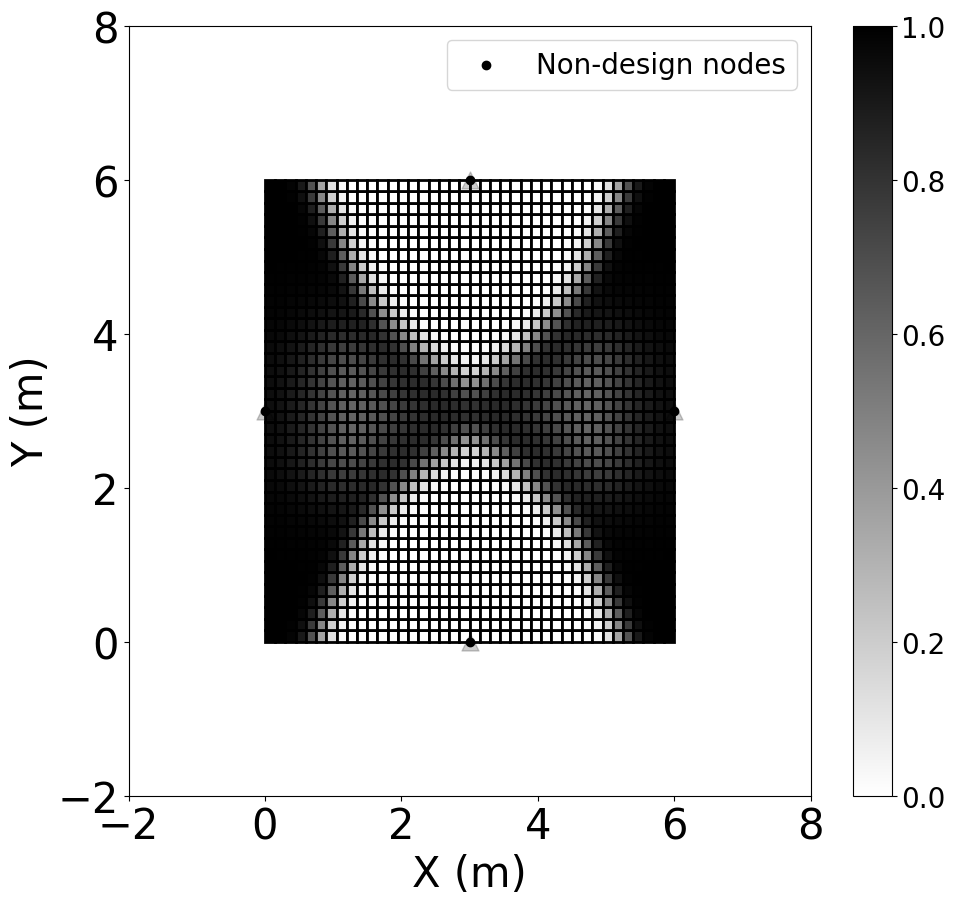

 95%|█████████▌| 195/205 [10:13<00:31,  3.14s/it]

Iter195, alpha=9.85, p=8.0


 96%|█████████▌| 196/205 [10:16<00:27,  3.00s/it]

Train epoch 197  ,loss:0.0873546222490025
Iter196, alpha=9.9, p=8.0


 96%|█████████▌| 197/205 [10:19<00:23,  2.90s/it]

Train epoch 198  ,loss:0.08718209575301006
Iter197, alpha=9.950000000000001, p=8.0


 97%|█████████▋| 198/205 [10:21<00:19,  2.83s/it]

Train epoch 199  ,loss:0.08701148811314759
Iter198, alpha=10.0, p=8.0


 97%|█████████▋| 199/205 [10:24<00:16,  2.78s/it]

Train epoch 200  ,loss:0.08684238311949072
Iter199, alpha=10.05, p=8.0
Train epoch 201  ,loss:0.08667295278240372
806.6815873860257


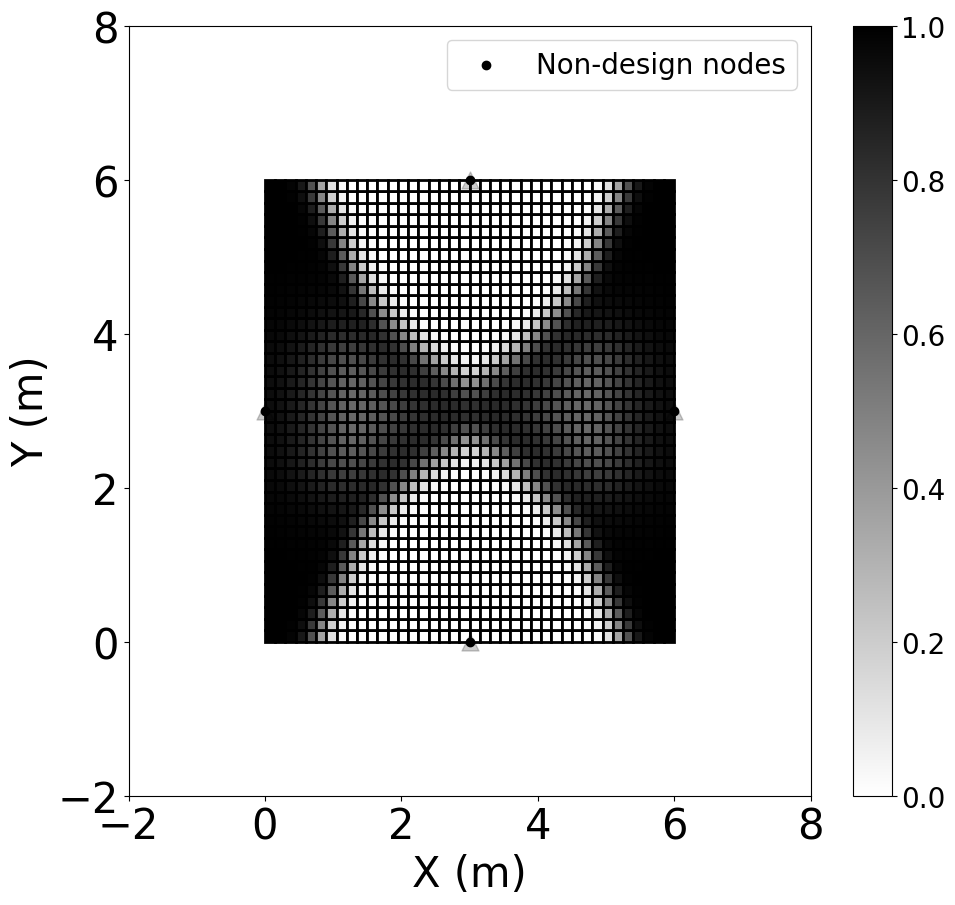

 98%|█████████▊| 200/205 [10:28<00:16,  3.23s/it]

Iter200, alpha=10.1, p=8.0


 98%|█████████▊| 201/205 [10:31<00:12,  3.06s/it]

Train epoch 202  ,loss:0.08650442684946999
Iter201, alpha=10.15, p=8.0


 99%|█████████▊| 202/205 [10:34<00:08,  2.94s/it]

Train epoch 203  ,loss:0.0863380477072295
Iter202, alpha=10.200000000000001, p=8.0


 99%|█████████▉| 203/205 [10:36<00:05,  2.86s/it]

Train epoch 204  ,loss:0.08617204274303161
Iter203, alpha=10.25, p=8.0


100%|█████████▉| 204/205 [10:39<00:02,  2.80s/it]

Train epoch 205  ,loss:0.08600761617674753
Iter204, alpha=10.3, p=8.0
Train epoch 206  ,loss:0.08584332713613264
806.3768721342524


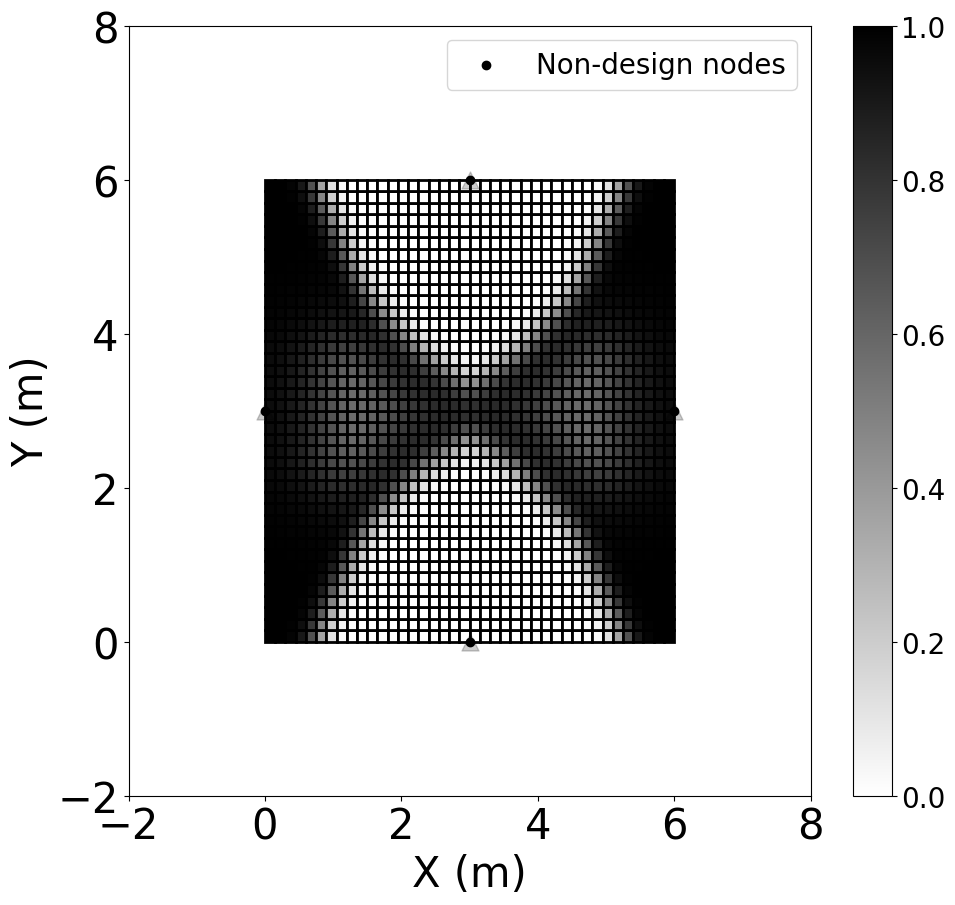

100%|██████████| 205/205 [10:43<00:00,  3.14s/it]


In [30]:
trained_model_state = train_model(model_state, num_epochs=205)

In [31]:
##Apply_fn: ML input to output
outs = trained_model_state.apply_fn(trained_model_state.params, inp) #how to move nodes along z, ML-Outpu
node_params = outs[:,0]
node_rho_params = outs[:,1]

#Final-Z
zs[design_nodes] = og_p(node_params)
zs_filtered = zs.copy()
zs_filtered[design_nodes] =(B_ij@zs)[design_nodes]

#Final density
mu_opt = jnp.average(node_rho_params[cnct],axis=1) #Average per-node density for each shell

In [42]:
outs[:,0]

Array([0.15064163, 0.30012599, 0.54851817, ..., 0.54851817, 0.30012599,
       0.15064163], dtype=float64)

In [130]:
design_nodes[20]

20

In [123]:
zs[non_design_nodes]

array([0.53679601, 2.9963183 , 1.62004906, 1.69808352])

# Visualization

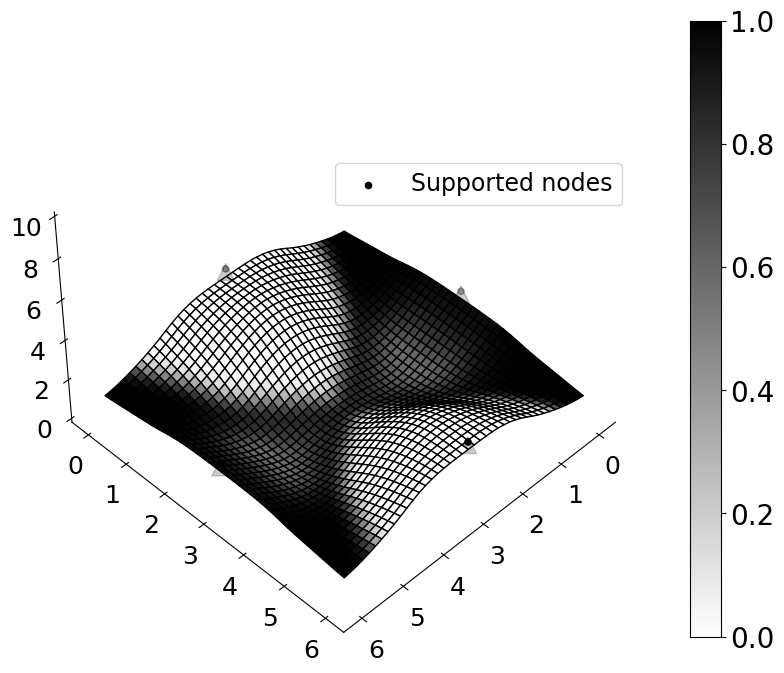

In [38]:
%matplotlib inline




fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(projection='3d')
ax.set_zlim(0,10)
#ax.set_xlabel('X (m)',fontsize=15)
#ax.set_ylabel('Y (m)',fontsize=15)
#ax.set_zlabel('Z (m)',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
#Plot a basic wireframe.
#for i in range(n_ele_bar):
  #ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],[z_ele[i,0],z_ele[i,1]],color='black')


import matplotlib as mpl
cmap = mpl.colormaps['binary']
mu_opt_filtered = B_ij_shell@mu_opt
for i in range(n_ele):
    all_corners = []
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    all_corners.append([[xs[inode],ys[inode],zs_filtered[inode]],
                        [xs[jnode],ys[jnode],zs_filtered[jnode]],
                        [xs[mnode],ys[mnode],zs_filtered[mnode]],
                        [xs[nnode],ys[nnode],zs_filtered[nnode]],
                       ])
    #all_corners.append([[xs[inode],ys[inode],zs[inode]],
    #                    [xs[jnode],ys[jnode],zs[jnode]],
    #                    [xs[mnode],ys[mnode],zs[mnode]],
    #                    [xs[nnode],ys[nnode],zs[nnode]],
    #                   ])
    
    tdco = Poly3DCollection(all_corners)
    alpha = float(mu_opt_filtered[i])
    tdco.set_facecolor(cmap(alpha))
    tdco.set_edgecolor('black')
    ax.add_collection3d(tdco)
    


cb = plt.colorbar(mpl.cm.ScalarMappable( cmap=cmap), ax=ax)
cb.ax.tick_params(labelsize=20)
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs_filtered[non_design_nodes]+0.35,color='black',label='Supported nodes')
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs_filtered[non_design_nodes]+0.2,s=150,marker='^',alpha=0.2,color='black')
ax.view_init(45,45)
plt.legend(fontsize=17, loc=(0.5,0.7))
ax.grid(False)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
plt.show()

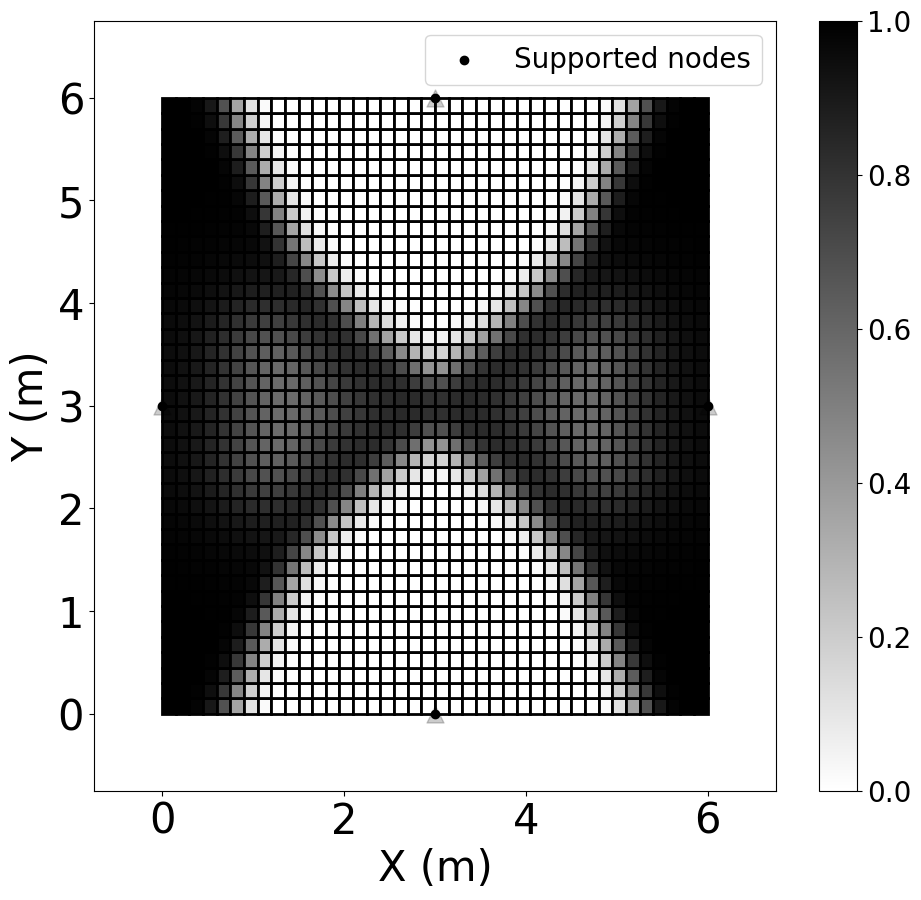

In [33]:

fig,ax = plt.subplots(figsize=(11,10))
ax.set_ylim(-0.75,6.75)
ax.set_xlim(-0.75,6.75)
plt.xlabel('X (m)',fontsize=30)
plt.ylabel('Y (m)',fontsize=30)
#ax = fig.add_subplot#(projection='3d')
#ax.set_zlim(0,20)
#ax.set_xlabel('X (m)',fontsize=15)
#ax.set_ylabel('Y (m)',fontsize=15)
#ax.set_zlabel('Z (m)',fontsize=15)
all_corners= []
import matplotlib as mpl
cmap = mpl.colormaps['binary']
for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    this_poly = Polygon([(xs[inode],ys[inode]), (xs[jnode],ys[jnode]), (xs[mnode],ys[mnode]),(xs[nnode],ys[nnode]),])
    alpha = float(mu_opt_filtered[i])
    #cthis_poly.set_alpha(alpha)
    this_poly.set_facecolor(cmap(alpha))
    this_poly.set_edgecolor('black')
    this_poly.set_lw(2)
    ax.add_patch(this_poly)

ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=30)
#Plot a basic wireframe.
#for i in range(n_ele_bar):
##  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],color='darkcyan')

ax.scatter(xs[non_design_nodes],ys[non_design_nodes],color='black',label='Supported nodes')
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],s=150,marker='^',alpha=0.2,color='black')


cb = plt.colorbar(mpl.cm.ScalarMappable( cmap=cmap), ax=ax)
cb.ax.tick_params(labelsize=20)
plt.legend(fontsize=20)# loc=(0.5,0.7))
ax.grid(False)
plt.show()

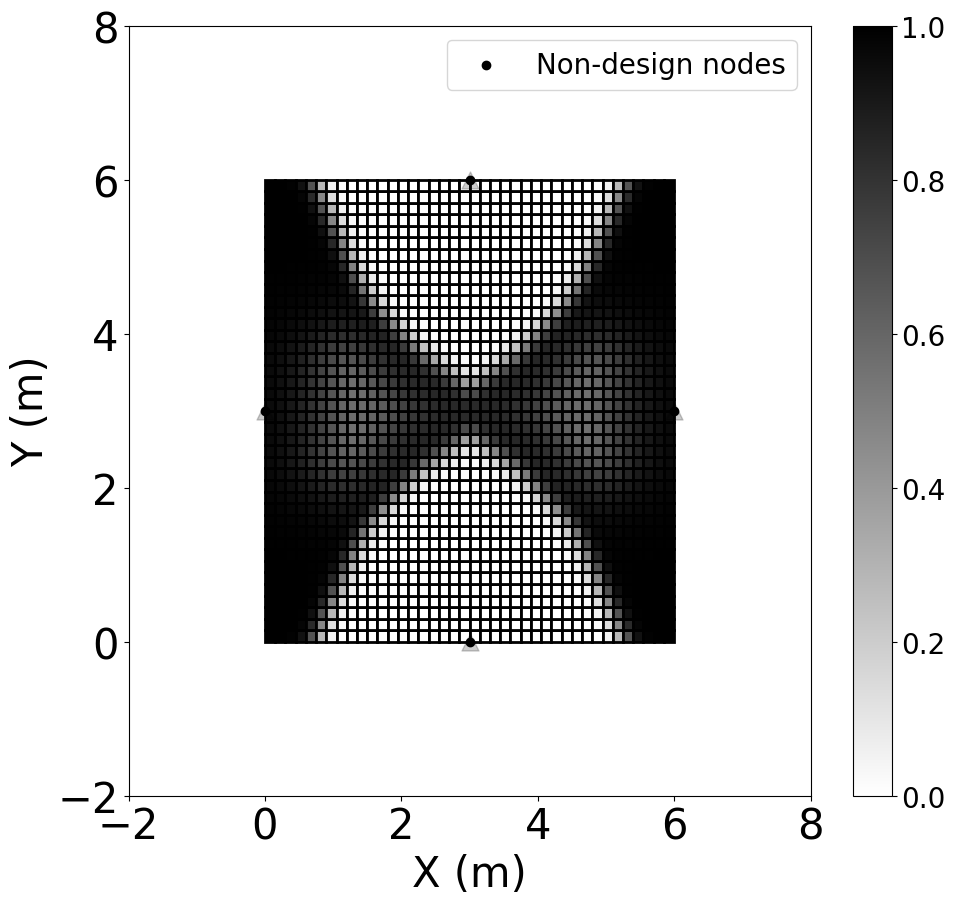

In [34]:

fig,ax = plt.subplots(figsize=(11,10))
ax.set_ylim(-2,8)
ax.set_xlim(-2,8)
plt.xlabel('X (m)',fontsize=30)
plt.ylabel('Y (m)',fontsize=30)
#ax = fig.add_subplot#(projection='3d')
#ax.set_zlim(0,20)
#ax.set_xlabel('X (m)',fontsize=15)
#ax.set_ylabel('Y (m)',fontsize=15)
#ax.set_zlabel('Z (m)',fontsize=15)
all_corners= []
import matplotlib as mpl
cmap = mpl.colormaps['binary']
for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    this_poly = Polygon([(xs[inode],ys[inode]), (xs[jnode],ys[jnode]), (xs[mnode],ys[mnode]),(xs[nnode],ys[nnode]),])
    alpha = float(mu_opt[i])
    #cthis_poly.set_alpha(alpha)
    this_poly.set_facecolor(cmap(alpha))
    this_poly.set_edgecolor('black')
    this_poly.set_lw(2)
    ax.add_patch(this_poly)

ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=30)
#Plot a basic wireframe.
#for i in range(n_ele_bar):
##  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],color='darkcyan')

ax.scatter(xs[non_design_nodes],ys[non_design_nodes],color='black',label='Non-design nodes')
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],s=150,marker='^',alpha=0.2,color='black')


cb = plt.colorbar(mpl.cm.ScalarMappable( cmap=cmap), ax=ax)
cb.ax.tick_params(labelsize=20)
plt.legend(fontsize=20)# loc=(0.5,0.7))
ax.grid(False)
plt.show()

In [106]:
jnp.sum(mu_opt)

Array(800.34499146, dtype=float64)

In [107]:
jnp.sum(mu_opt)

Array(800.34499146, dtype=float64)

In [108]:
0.5*sso_model.eleparameters_values.shape[0]

800.0

In [ ]:
mu_opt_filtered

In [82]:
jnp.min(mu_opt)

Array(0.49547004, dtype=float64)

In [83]:
jnp.max(mu_opt)

Array(0.54537502, dtype=float64)

In [86]:
jnp.max(model_state.apply_fn(params, inp)[:,1])

Array(0.52117628, dtype=float64)

In [87]:
jnp.min(model_state.apply_fn(params, inp)[:,1])

Array(0.5, dtype=float64)

In [89]:
np.max(zs)

1.827663999013847

In [90]:
np.min(zs)

1.4122399536942798